# Pandas Workbook for VCN to TSV converted variant calls

This workbook takes tsv formatted variant calls (originally from GATK Mutect2) and applies further filtering and displays mutation spectra as well as zygosity on chromosome maps 

## Set Up The Environment
- Import Libraries and Create Directory Structure
- Define Functions
- Define chromosome set

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from natsort import index_natsorted
import seaborn as sns
from numpy.core.numeric import NaN
!mkdir figures

################################################################################

def dataFrameImport(directory):
  frames_list_samples = []
  sample_names = []

  counter=1
  for filename in os.listdir(directory):
      if filename.endswith(".tsv"):
          sample_names.append(filename[:10].strip())
          path = os.path.join(directory, filename)
          globals()[f"sample{counter}"] = pd.read_csv(path, sep='\t')
          print(f'dataframe {sample_names[-1]} has {len(globals()[f"sample{counter}"])} total rows')
          frames_list_samples.append(globals()[f"sample{counter}"])
          counter+=1
  print(f"found {len(frames_list_samples)} samples in {directory}")
  print(len(sample_names), sample_names)

  return(frames_list_samples, sample_names)

def qualitySNPFilter(frames_list):

  for i in range(len(frames_list)):
    frames_list[i] = frames_list[i][frames_list[i].TYPE =='SNP']
    frames_list[i] = frames_list[i].rename(columns=lambda c: 'AF' if 'AF' in c else c)
    frames_list[i] = frames_list[i].rename(columns=lambda c: 'AD' if 'AD' in c else c)
    
    #this line may be problematic for a good result and if not needed comment out
    frames_list[i]['AF'] = frames_list[i].apply(lambda row: findDominantAF(row), axis=1)

    frames_list[i] = frames_list[i].astype({'AF': float})
    frames_list[i] = frames_list[i][frames_list[i].AF >= 0.35]
    #also filter out 1.5n variants?

    frames_list[i]['EVAL_AD'] = frames_list[i].apply(lambda row: filterByAD(row), axis=1)
    frames_list[i] = frames_list[i][frames_list[i].EVAL_AD == 'True']
    frames_list[i]['SPECTRA'] = frames_list[i].apply(lambda row: findType(row.REF, row.ALT), axis=1)
  return frames_list

def filterByAD(row):
  reads=row['AD'].split(",")
  if int(reads[1]) < 5:
    return "False"
  if int(reads[0])+int(reads[1]) > 9:
    return "True"
  else:
    return "False"

def findDominantAF(row):
  reads=row['AF'].split(",")
  return(max(reads))

def findType(colA, colB):
  if ((colA == 'C') & (colB == 'T') | (colA == 'G') & (colB == 'A')):
    return('C_to_T')
  if ((colA == 'C') & (colB == 'A') | (colA == 'G') & (colB == 'T')):
    return('C_to_A')
  if ((colA == 'C') & (colB == 'G') | (colA == 'G') & (colB == 'C')):
    return('C_to_G')
  if ((colA == 'T') & (colB == 'C') | (colA == 'A') & (colB == 'G')):
    return('T_to_C')
  if ((colA == 'T') & (colB == 'G') | (colA == 'A') & (colB == 'C')):
    return('T_to_G')
  if ((colA == 'T') & (colB == 'A') | (colA == 'A') & (colB == 'T')):
    return('T_to_A')

def findZygosity(row):
  if (row["AF"] >= 0.85):
    return('Homozygous')
  else:
    return('Heterozygous')

def filterFromClones(frames_list):
  #this will subtract all common rows between normal/control and experimental
  #sample. I might need to revist to filter variants by position only not all columns
  subtracted_df_list = []
  for df in frames_list:
    temp_df = df.drop(columns=['AD','AF'])
    len_original=len(temp_df)
    for df_2 in frames_list:
      if not df.equals(df_2):
        df_2=df_2.drop(columns=['AD','AF'])
        temp_df = pd.merge(temp_df,df_2, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

    len_final=len(temp_df)
    print(f"removed {len_original-len_final} rows from df")
    subtracted_df_list.append(temp_df)
  return subtracted_df_list

def drawSNPMap(pd_df, df_chr_lengths, chr_starts_df, title, sample_names, saveMap=True):

  pd_df = pd_df.append(chr_starts_df, ignore_index=True)

  fig, ax = plt.subplots()

  df_chr_lengths.plot(kind='barh',legend=False, ax=ax, x="chromosome", y="end_position", fontsize=15, figsize=(20,6), edgecolor="black", linewidth=1, color="beige", zorder=0, title=title, label="Position")
  
  pd_df = pd_df.sort_values(by="CHROM", key=lambda x: np.argsort(index_natsorted(pd_df["CHROM"])))
  
  #To rename legend elements, change plot markers/colors, modify here
  label_dict = { "G": "G->N", "C": "C->N", "A": "A->N", "T": "T->N", "REF": "Reference Allele"}
  markers = {"Homozygous": "x", "Heterozygous": "|"}
  palette = {"G": "green", "C": "red", "A": "gray", "T": "gray"}

  sns.scatterplot(ax=ax,data=pd_df, x="POS", y="CHROM", hue="REF", palette=palette, style="ZYGOSITY", markers=markers, s=120, alpha=0.7,zorder=1, linewidth=1.5)
  
  ax.set_xlabel("POSITION")
  ax.set_ylabel("CHROMOSOME")

  legend_texts = plt.legend().get_texts()
  for i in range(len(legend_texts)):
    label_str = legend_texts[i].get_text()
    if label_str in label_dict:
      new_label = label_dict.get(label_str)

      legend_texts[i].set_text(new_label)

  if saveMap:
    plt.savefig('figures/'+title+'.png', transparent=False)


def findGenomeLength(chromosomes):

  genome_length = 0
  for chr in chromosomes:
    genome_length+=chr[1]

  return(genome_length)

def generateRandomLoci(n, chromosomes):

  genome_length=findGenomeLength(chromosomes)
  return(random.sample(range(0, genome_length), n))

def findChrInLinearGenome(chromosomes, random_loci):

  output_list=[]
  for locus in random_loci:
    linear_genome_slider=0
    linear_genome_slider_previous=0
    for chromosome in chromosomes:
      linear_genome_slider+=chromosome[1]

      if locus < linear_genome_slider:
        #print(f'slider:{linear_genome_slider}, chr:{chromosome[0]}, locus:{locus}')
        output_list.append([chromosome[0], locus-linear_genome_slider_previous])
        linear_genome_slider_previous+=chromosome[1]
        break
      linear_genome_slider_previous+=chromosome[1]

  return(output_list)

def findSpectraStrandwise(colA, colB):
  if ((colA == 'C') & (colB == 'T')):
    return('C_to_T')
  elif ((colA == 'C') & (colB == 'A')):
    return('C_to_A')
  elif ((colA == 'C') & (colB == 'G')):
    return('C_to_G')
  elif ((colA == 'T') & (colB == 'C')):
    return('T_to_C')
  elif ((colA == 'T') & (colB == 'G')):
    return('T_to_G')
  elif ((colA == 'T') & (colB == 'A')):
    return('T_to_A')

  elif ((colA == 'G') & (colB == 'A')):
    return('G_to_A')
  elif ((colA == 'G') & (colB == 'T')):
    return('G_to_T')
  elif ((colA == 'G') & (colB == 'C')):
    return('G_to_C')
  elif ((colA == 'A') & (colB == 'G')):
    return('A_to_G')
  elif ((colA == 'A') & (colB == 'C')):
    return('A_to_C')
  elif ((colA == 'A') & (colB == 'T')):
    return('A_to_T')

def renameChrToRoman(df):
  roman_names={"chr1": "I",
               "chr2": "II",
               "chr3": "III",
               "chr4": "IV",
               "chr5": "V",
               "chr6": "VI",
               "chr7": "VII",
               "chr8": "VIII",
               "chr9": "IX",
               "chr10": "X",
               "chr11": "XI",
               "chr12": "XII",
               "chr13": "XIII",
               "chr14": "XIV",
               "chr15": "XV",
               "chr16": "XVI"}
  df.replace({"chromosome": roman_names}, inplace=True)
  return(df)


def draw_random_SNPMap(pd_df, df_chr_lengths, chr_starts_df, title, saveMap=True):

  #To rename legend elements, change plot markers/colors, modify here

  label_dict = {"cen": 'Centromere'}
  markers = {"random": "$|$", "cen": "o"}
  palette = {"random": "black", "cen": "white"}

  
  pd_df = pd_df.append(chr_starts_df, ignore_index=True)
  pd_df = pd_df.sort_values(by="CHROM", key=lambda x: np.argsort(index_natsorted(pd_df["CHROM"])))
  renameChrToRoman(pd_df)


  fig, ax = plt.subplots()

  renameChrToRoman(df_chr_lengths)

  df_chr_lengths.plot(kind='barh',legend=False, ax=ax, x="chromosome", y="end_position", fontsize=40, figsize=(80,24), edgecolor="black", linewidth=1, color="lightgray", zorder=0, label="Position")
  sns.scatterplot(ax=ax, data=pd_df, x="POS", y="CHROM", style="REF", markers=markers, hue="REF", palette=palette, s=1500, alpha=1,zorder=1, linewidth=1, edgecolor="black", legend=False)

  ax.set_xlabel("POSITION", fontsize=40)
  ax.set_ylabel("CHROMOSOME", fontsize=40)
  fig.suptitle(title, fontsize=60)

  legend_texts = plt.legend().get_texts()
  for i in range(len(legend_texts)):
    label_str = legend_texts[i].get_text()
    if label_str in label_dict:
      new_label = label_dict.get(label_str)

      legend_texts[i].set_text(new_label)

  if saveMap:
    plt.savefig('figures/'+title+'.png', transparent=False, dpi=200)

def drawCombinedSNPMap(pd_df, df_chr_lengths, chr_starts_df, title, sample_names, saveMap=True):

  #To rename legend elements, change plot markers/colors, modify here
  label_dict = { "G": "G->N",
                 "C": "C->N",
                 "A": "A->N",
                 "T": "T->N",
                 "SPECTRA_STRANDWISE": "Reference Allele",
                 "cen": 'Centromere'}
                
  markers = {"C_to_T": "$|$",
             "C_to_A": "$|$",
             "C_to_G": "$|$",
             "G_to_A": "$|$",
             "G_to_C": "$|$",
             "G_to_T": "$|$",
             'T_to_A': "$|$",
             'T_to_C': "$|$",
             'A_to_C': "$|$",
             'A_to_G': "$|$",
             'A_to_T': "$|$",
             'T_to_G': "$|$",
             'cen': "o"}

  palette = {"C_to_T": "black",
             "C_to_A": "black",
             "C_to_G": "black",
             "G_to_A": "red",
             "G_to_C": "blue",
             "G_to_T": "olive",
             'T_to_A': "gray",
             'T_to_C': "gray",
             'A_to_C': "gray",
             'A_to_G': "gray",
             'A_to_T': "gray",
             'T_to_G': "gray",
             'cen': "white"}

  pd_df = pd_df.append(chr_starts_df, ignore_index=True)
  pd_df = pd_df.sort_values(by="CHROM", key=lambda x: np.argsort(index_natsorted(pd_df["CHROM"])))
  renameChrToRoman(pd_df)
  
  fig, ax = plt.subplots()

  renameChrToRoman(df_chr_lengths)
  df_chr_lengths.plot(kind='barh',legend=False, ax=ax, x="chromosome", y="end_position", fontsize=10, figsize=(20,6), edgecolor="black", linewidth=1, color="lightgray", zorder=0, label="Position")

  sns.scatterplot(ax=ax, data=pd_df[pd_df["REF"].isin(["C",'cen'])], x="POS", y="CHROM", hue="SPECTRA_STRANDWISE", palette=palette, style="SPECTRA_STRANDWISE", markers=markers, s=100, alpha=.9,zorder=1, linewidth=.05, edgecolor="black", legend = False)
  sns.scatterplot(ax=ax, data=pd_df[pd_df["REF"].isin(["G",'cen'])], x="POS", y="CHROM", hue="SPECTRA_STRANDWISE", palette=palette, style="SPECTRA_STRANDWISE", markers=markers, s=100, alpha=.9,zorder=2, linewidth=.15, edgecolor="black")

  ax.set_xlabel("POSITION", fontsize=10)
  ax.set_ylabel("CHROMOSOME", fontsize=10)
  fig.suptitle(title, fontsize=15)

  legend_texts = plt.legend().get_texts()
  for i in range(len(legend_texts)):
    label_str = legend_texts[i].get_text()
    if label_str in label_dict:
      new_label = label_dict.get(label_str)
      legend_texts[i].set_text(new_label)

  if saveMap:
    plt.savefig('figures/'+title+'.png', transparent=False, dpi=600)

################################################################################
# Set Reference Chromosomal Intervals for figure drawing and create a DataFrame
chromosomes = [['chr1', 213104],
               ['chr2',808582],
               ['chr3',311908],
               ['chr4',1530212],
               ['chr5',575767],
               ['chr6',270154],
               ['chr7',1087636],
               ['chr8',558124],
               ['chr9',434235],
               ['chr10',738684],
               ['chr11',666289],
               ['chr12',1076120],
               ['chr13',924256],
               ['chr14',784073],
               ['chr15',1091289],
               ['chr16',948058]]
columns = ["chromosome", "end_position"]

df_chr = pd.DataFrame(chromosomes, columns = columns, dtype = int)

starts = pd.DataFrame([['chr1', 0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr2',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr3',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr4',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr5',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr6',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr7',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr8',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr9',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr10',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr11',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr12',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr13',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr14',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr15',0, "ctrl", NaN, NaN, NaN, NaN],
          ['chr16',0, "ctrl", NaN, NaN, NaN, NaN]], 
          columns=["CHROM", "POS", "TYPE","EVAL_AD", "REF","ALT", "SPECTRA"])


centromeres = pd.DataFrame([['chr1', 151582, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr2',238323, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr3',114501, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr4',449821, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr5',152104, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr6',148627, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr7',497038, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr8',105703, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr9',355745, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr10',436425, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr11',440246, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr12',150947, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr13',268149, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr14',628875, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr15',326702, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"],
                      ['chr16',556073, "ctrl", NaN, "cen", NaN, NaN,"cen","cen"]], 
                      columns=["CHROM", "POS", "TYPE","EVAL_AD", "REF","ALT", "SPECTRA","SPECTRA_STRANDWISE","ZYGOSITY"])

## Upload Datasets
Set the `path` to the location of directory containing mutation calls in the .tsv file format

In [16]:
#Create Pandas DataFrames for each calls file
path ='/content'
frames_list, sample_names = dataFrameImport(path)

dataframe JT38_CSFP2 has 459 total rows
dataframe JT34_CSFP2 has 460 total rows
dataframe JT14_CSFP2 has 300 total rows
dataframe JT49_CSFP2 has 344 total rows
dataframe JT43_CSFP2 has 513 total rows
dataframe JT54_CSFP2 has 329 total rows
dataframe JT15_CSFP2 has 507 total rows
dataframe JT26_CSFP2 has 374 total rows
dataframe JT9_CSFP21 has 570 total rows
dataframe JT3_CSFP21 has 1017 total rows
dataframe JT12_CSFP2 has 325 total rows
dataframe JT7_CSFP21 has 523 total rows
dataframe JT44_CSFP2 has 609 total rows
dataframe JT32_CSFP2 has 439 total rows
dataframe JT45_CSFP2 has 548 total rows
dataframe JT55_CSFP2 has 575 total rows
dataframe JT28_CSFP2 has 317 total rows
dataframe JT21_CSFP2 has 266 total rows
dataframe JT1_CSFP21 has 2109 total rows
dataframe JT40_CSFP2 has 437 total rows
dataframe JT48_CSFP2 has 579 total rows
dataframe JT10_CSFP2 has 442 total rows
dataframe JT58_CSFP2 has 451 total rows
dataframe JT37_CSFP2 has 367 total rows
dataframe JT60_CSFP2 has 573 total row

## Dataset Filtering

In [17]:
#Set the name for the output csv file containing filtered SNP positions
outputCSV = 'filtered_no_commons_SNPs.csv'

#filter the SNP calls by quality (details under qualitySNPFilter function)
frames_list = qualitySNPFilter(frames_list)

#remove positions that are common among biological replicates/clones
subtracted_df_list = filterFromClones(frames_list)

# add back AD and AF to subtracted_df_list after removing commons
for i in range(len(subtracted_df_list)):
  subtracted_df_list[i] = pd.merge(subtracted_df_list[i], frames_list[i], on=["CHROM", "POS","TYPE", "REF","ALT", "EVAL_AD", "SPECTRA"])

#determine zygosity
for i in range(len(subtracted_df_list)):
  subtracted_df_list[i]["ZYGOSITY"] = subtracted_df_list[i].apply(lambda row: findZygosity(row), axis=1)
  print(subtracted_df_list[i])

for i in range(len(frames_list)):
  frames_list[i]["ZYGOSITY"] = frames_list[i].apply(lambda row: findZygosity(row), axis=1)
  print(frames_list[i])

master_df = pd.DataFrame()
for i in range(len(subtracted_df_list)):
  print(f'adding df of length {len(subtracted_df_list[i])} to master')
  temp_df = subtracted_df_list[i]
  temp_df["Sample_Name"] = sample_names[i].split("_")[0]
  master_df = master_df.append(temp_df, ignore_index = True)

  print("added df to master...")

print("Finished creating MaserDF!")
master_df.to_csv(outputCSV, index=False)
print(master_df)

removed 17 rows from df
removed 11 rows from df
removed 16 rows from df
removed 30 rows from df
removed 34 rows from df
removed 25 rows from df
removed 11 rows from df
removed 13 rows from df
removed 9 rows from df
removed 7 rows from df
removed 18 rows from df
removed 14 rows from df
removed 63 rows from df
removed 12 rows from df
removed 37 rows from df
removed 41 rows from df
removed 12 rows from df
removed 13 rows from df
removed 7 rows from df
removed 17 rows from df
removed 24 rows from df
removed 14 rows from df
removed 39 rows from df
removed 16 rows from df
removed 41 rows from df
removed 14 rows from df
removed 26 rows from df
removed 19 rows from df
removed 66 rows from df
removed 18 rows from df
removed 34 rows from df
removed 45 rows from df
removed 25 rows from df
removed 19 rows from df
removed 16 rows from df
removed 4 rows from df
removed 18 rows from df
removed 16 rows from df
removed 41 rows from df
removed 15 rows from df
removed 34 rows from df
removed 16 rows from

In [12]:
#you can check all SNPs on just chr3 here:
master_df_filtered = master_df[master_df["CHROM"] == "chr3"]
master_df_filtered

,CHROM,POS,TYPE,REF,ALT,EVAL_AD,SPECTRA,AD,AF,ZYGOSITY,Sample_Name
0,chr3,17264,SNP,G,A,True,C_to_T,"138,138",0.498,Heterozygous,JT38
1,chr3,154301,SNP,C,G,True,C_to_G,"88,95",0.519,Heterozygous,JT38
2,chr3,164698,SNP,C,G,True,C_to_G,"108,98",0.477,Heterozygous,JT38
3,chr3,171749,SNP,C,T,True,C_to_T,"95,96",0.505,Heterozygous,JT38
4,chr3,184372,SNP,C,T,True,C_to_T,"89,110",0.553,Heterozygous,JT38
...,...,...,...,...,...,...,...,...,...,...,...
2317,chr3,157394,SNP,C,T,True,C_to_T,"252,152",0.380,Heterozygous,JT19
2319,chr3,157520,SNP,C,G,True,C_to_G,"107,145",0.572,Heterozygous,JT22
2320,chr3,182019,SNP,C,T,True,C_to_T,"85,135",0.609,Heterozygous,JT22
2321,chr3,249220,SNP,C,G,True,C_to_G,"122,116",0.487,Heterozygous,JT22


## Drawing Figures

Plotting all mutations for all samples genomewide. Can set the following by commenting/uncommenting lines:
- just G->N and C->N
- just G->N
- just on chromosome 3
- just on chromosome 3 R

caveats: if the particular sample has no SNPs to be drawn, it will return empty diagram with blue circles at the beginning of each chromosome. This should be ignored.

Plots also show which mutations are Heterozygous and Homozygous.

All figures are saved in figures folder under their sample names.

JT38_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3   17264   SNP    G    A    True  C_to_T  138,138  0.498   
1    chr3  154301   SNP    C    G    True  C_to_G    88,95  0.519   
2    chr3  164698   SNP    C    G    True  C_to_G   108,98  0.477   
3    chr3  171749   SNP    C    T    True  C_to_T    95,96  0.505   
4    chr3  184372   SNP    C    T    True  C_to_T   89,110  0.553   
5    chr3  184381   SNP    C    G    True  C_to_G   92,113  0.549   
6    chr3  186348   SNP    C    G    True  C_to_G  104,117  0.528   
7    chr3  187437   SNP    C    T    True  C_to_T   95,115  0.545   
8    chr3  238946   SNP    C    T    True  C_to_T  127,136  0.517   
9    chr3  264782   SNP    C    G    True  C_to_G  142,118  0.455   
10   chr3  281108   SNP    C    T    True  C_to_T  112,106  0.487   
11   chr9  129369   SNP    G    A    True  C_to_T     1,97  0.973   
12   chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr2       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT10_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF      ZYGOSITY  \
0   chr14  414864   SNP    T    C    True  T_to_C  23,21  0.496  Heterozygous   
1    chr1       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
2    chr2       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
3    chr3       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
4    chr4       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
5    chr5       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
6    chr6       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
7    chr7       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
8    chr8       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
9    chr9       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
10  chr10       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
11  chr11       0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT58_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA    AD     AF    ZYGOSITY  \
0     chr1   51845   SNP    G    A    True  C_to_T  0,87  1.000  Homozygous   
1     chr2   23936   SNP    G    A    True  C_to_T  0,62  0.984  Homozygous   
2     chr2  250960   SNP    G    A    True  C_to_T  0,60  0.990  Homozygous   
3     chr2  629056   SNP    G    A    True  C_to_T  0,51  0.981  Homozygous   
4     chr2  794540   SNP    C    T    True  C_to_T  0,62  0.984  Homozygous   
..     ...     ...   ...  ...  ...     ...     ...   ...    ...         ...   
96   chr12       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
97   chr13       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
98   chr14       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
99   chr15       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
100  chr16       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   

    Sample_Name  
0          JT58  
1   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT37_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  193085   SNP    C    G    True  C_to_G  162,128  0.445   
1    chr3  215143   SNP    C    G    True  C_to_G    0,333  0.985   
2    chr3  221544   SNP    C    T    True  C_to_T    0,361  0.991   
3    chr3  237690   SNP    C    T    True  C_to_T    0,277  0.973   
4    chr3  243887   SNP    C    G    True  C_to_G    0,337  0.993   
5    chr3  247414   SNP    C    T    True  C_to_T    0,332  0.986   
6    chr3  289868   SNP    C    T    True  C_to_T    2,414  0.986   
7    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr7       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT60_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF  \
0     chr2  328160   SNP    C    T    True  C_to_T   0,33  0.971   
1     chr2  531914   SNP    G    A    True  C_to_T   0,40  0.988   
2     chr3  110122   SNP    C    T    True  C_to_T  45,34  0.433   
3     chr3  147429   SNP    C    T    True  C_to_T  56,39  0.414   
4     chr3  152615   SNP    C    T    True  C_to_T  28,38  0.574   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...   
150  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
151  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
152  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
153  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
154  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   

         ZYGOSITY Sample_Name  
0      Homozygous        JT60  
1      Homozygous        JT60  
2    Heterozygous        JT60  
3    Heterozygous        JT60  
4    Heteroz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT25_CSFP2
    CHROM      POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr2   799193   SNP    C    T    True  C_to_T  313,172  0.361   
1    chr3   236595   SNP    G    A    True  C_to_T  157,151  0.491   
2    chr3   239765   SNP    G    C    True  C_to_G  148,144  0.493   
3    chr3   252062   SNP    C    T    True  C_to_T    0,344  0.981   
4    chr3   254412   SNP    G    C    True  C_to_G  142,172  0.546   
5    chr3   255325   SNP    G    C    True  C_to_G  137,121  0.472   
6    chr3   260472   SNP    C    G    True  C_to_G    0,281  0.975   
7    chr3   266892   SNP    C    T    True  C_to_T  158,141  0.474   
8    chr3   273868   SNP    C    G    True  C_to_G  150,139  0.481   
9    chr3   278059   SNP    C    T    True  C_to_T  143,146  0.505   
10   chr3   289420   SNP    G    A    True  C_to_T  200,178  0.470   
11   chr3   290964   SNP    G    A    True  C_to_T  217,207  0.489   
12   chr3   301893   SNP    C    T    True  C_to_T  316,185  0.371   
13   chr7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT51_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr1  192762   SNP    A    T    True  T_to_A     0,11  1.000   
1    chr2  350633   SNP    G    A    True  C_to_T     0,71  0.960   
2    chr2  609556   SNP    G    A    True  C_to_T     0,90  0.983   
3    chr2  795616   SNP    G    A    True  C_to_T    0,135  0.981   
4    chr3  159790   SNP    C    T    True  C_to_T  109,109  0.500   
..    ...     ...   ...  ...  ...     ...     ...      ...    ...   
81  chr12       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
82  chr13       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
83  chr14       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
84  chr15       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
85  chr16       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   

        ZYGOSITY Sample_Name  
0     Homozygous        JT51  
1     Homozygous        JT51  
2     Homozygous        JT51  
3     Homozygous        JT51  
4   H

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT39_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  104011   SNP    C    G    True  C_to_G  206,121  0.374   
1    chr3  108695   SNP    C    T    True  C_to_T   154,87  0.371   
2    chr3  116228   SNP    C    T    True  C_to_T  167,115  0.411   
3    chr3  116720   SNP    C    G    True  C_to_G  178,123  0.412   
4    chr3  124704   SNP    C    T    True  C_to_T  114,166  0.591   
5    chr3  125850   SNP    C    G    True  C_to_G  107,190  0.637   
6    chr3  126546   SNP    C    T    True  C_to_T  127,175  0.575   
7    chr3  131073   SNP    C    A    True  C_to_A  115,169  0.591   
8    chr3  133376   SNP    C    A    True  C_to_A  133,180  0.571   
9    chr3  135134   SNP    C    G    True  C_to_G  124,192  0.602   
10   chr3  138746   SNP    C    G    True  C_to_G  114,189  0.618   
11   chr3  140854   SNP    C    T    True  C_to_T  139,224  0.615   
12   chr3  144661   SNP    C    T    True  C_to_T  127,184  0.587   
13   chr3  173174   SNP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT53_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF    ZYGOSITY  \
0     chr1   66055   SNP    G    A    True  C_to_T  0,108  0.976  Homozygous   
1     chr2   74221   SNP    C    T    True  C_to_T   0,94  0.986  Homozygous   
2     chr2  165963   SNP    C    T    True  C_to_T   0,67  0.981  Homozygous   
3     chr2  278847   SNP    C    T    True  C_to_T   0,84  0.972  Homozygous   
4     chr2  362136   SNP    C    T    True  C_to_T   0,70  0.967  Homozygous   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...         ...   
248  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
249  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
250  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
251  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
252  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   

    Sample_Name  
0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT30_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  296948   SNP    G    C    True  C_to_G  129,138  0.515   
1    chr3  300380   SNP    G    C    True  C_to_G  224,141  0.391   
2   chr15  710423   SNP    C    A    True  C_to_A     0,79  0.969   
3    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
4    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
5    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
6    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr8       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr9       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12  chr10       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13  chr11       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT41_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr2  110526   SNP    C    T    True  C_to_T    0,126  0.976   
1    chr2  297781   SNP    G    A    True  C_to_T    0,129  0.987   
2    chr2  375699   SNP    G    A    True  C_to_T    0,105  0.989   
3    chr3  159809   SNP    C    T    True  C_to_T  141,150  0.512   
4    chr3  168658   SNP    C    T    True  C_to_T  152,140  0.479   
..    ...     ...   ...  ...  ...     ...     ...      ...    ...   
69  chr12       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
70  chr13       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
71  chr14       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
72  chr15       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
73  chr16       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   

        ZYGOSITY Sample_Name  
0     Homozygous        JT41  
1     Homozygous        JT41  
2     Homozygous        JT41  
3   Heterozygous        JT41  
4   H

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT57_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF  \
0     chr2  588371   SNP    C    T    True  C_to_T   0,25  0.963   
1     chr2  663846   SNP    C    T    True  C_to_T   0,24  0.980   
2     chr3  146343   SNP    C    T    True  C_to_T  39,34  0.471   
3     chr3  150577   SNP    C    T    True  C_to_T  41,34  0.455   
4     chr3  158738   SNP    C    T    True  C_to_T  38,27  0.422   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...   
99   chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
100  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
101  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
102  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
103  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   

         ZYGOSITY Sample_Name  
0      Homozygous        JT57  
1      Homozygous        JT57  
2    Heterozygous        JT57  
3    Heterozygous        JT57  
4    Heteroz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT47_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF    ZYGOSITY  \
0     chr2   45539   SNP    C    T    True  C_to_T  0,114  0.988  Homozygous   
1     chr2  270107   SNP    C    T    True  C_to_T  0,130  0.985  Homozygous   
2     chr2  381591   SNP    C    T    True  C_to_T  0,124  0.982  Homozygous   
3     chr2  418980   SNP    C    T    True  C_to_T  0,118  0.993  Homozygous   
4     chr2  473110   SNP    C    T    True  C_to_T   0,82  0.982  Homozygous   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...         ...   
114  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
115  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
116  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
117  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
118  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   

    Sample_Name  
0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT33_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  221742   SNP    C    A    True  C_to_A  122,135  0.525   
1    chr3  226480   SNP    C    G    True  C_to_G  147,132  0.475   
2    chr3  227651   SNP    C    T    True  C_to_T  137,137  0.501   
3    chr3  239086   SNP    C    G    True  C_to_G  105,141  0.569   
4    chr3  243326   SNP    C    T    True  C_to_T  121,157  0.564   
5    chr3  250717   SNP    C    G    True  C_to_G  133,150  0.529   
6    chr3  253130   SNP    C    G    True  C_to_G  149,145  0.493   
7    chr3  263209   SNP    C    T    True  C_to_T  161,128  0.444   
8    chr3  264838   SNP    C    T    True  C_to_T  122,168  0.578   
9    chr3  269331   SNP    C    T    True  C_to_T  121,172  0.584   
10   chr3  273402   SNP    C    T    True  C_to_T  136,120  0.470   
11   chr3  277516   SNP    C    T    True  C_to_T  124,107  0.464   
12   chr3  280506   SNP    C    T    True  C_to_T  134,151  0.529   
13   chr3  291772   SNP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT24_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA    AD     AF    ZYGOSITY  \
0    chr3  290009   SNP    C    G    True  C_to_G  0,75  1.000  Homozygous   
1   chr14  414822   SNP    T    C    True  T_to_C  1,23  0.879  Homozygous   
2    chr1       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
3    chr2       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
4    chr3       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
5    chr4       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
6    chr5       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
7    chr6       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
8    chr7       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
9    chr8       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
10   chr9       0  ctrl  NaN  NaN     NaN     NaN   NaN    NaN         NaN   
11  chr10       0  ctrl  NaN  NaN     NaN     NaN   N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT8_CSFP21
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF      ZYGOSITY  \
0    chr3  174214   SNP    C    G    True  C_to_G  57,48  0.458  Heterozygous   
1    chr3  182776   SNP    G    T    True  C_to_A  38,56  0.595  Heterozygous   
2    chr1       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
3    chr2       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
4    chr3       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
5    chr4       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
6    chr5       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
7    chr6       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
8    chr7       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
9    chr8       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
10   chr9       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
11  chr10       0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT35_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  173072   SNP    C    G    True  C_to_G   96,119  0.552   
1    chr3  265839   SNP    C    G    True  C_to_G  121,126  0.509   
2    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
3    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
4    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
5    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
6    chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr8       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr9       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11  chr10       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12  chr11       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13  chr12       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT13_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA      AD     AF  \
0    chr3  152535   SNP    C    T    True  C_to_T   94,79  0.458   
1    chr3  158352   SNP    C    G    True  C_to_G   83,90  0.516   
2    chr3  297274   SNP    C    G    True  C_to_G  95,116  0.550   
3    chr6   53718   SNP    G    A    True  C_to_T   0,105  0.984   
4    chr7  328138   SNP    G    C    True  C_to_G   0,101  0.966   
5    chr1       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
6    chr2       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
7    chr3       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
8    chr4       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
9    chr5       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
10   chr6       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
11   chr7       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
12   chr8       0  ctrl  NaN  NaN     NaN     NaN     NaN    NaN   
13   chr9       0  ctrl  NaN  NaN    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT50_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF  \
0     chr2   29267   SNP    C    T    True  C_to_T   0,56  0.979   
1     chr2   87959   SNP    C    T    True  C_to_T   7,33  0.800   
2     chr2  140851   SNP    C    T    True  C_to_T   0,57  0.973   
3     chr2  350251   SNP    C    T    True  C_to_T   9,43  0.802   
4     chr2  473028   SNP    C    T    True  C_to_T  17,26  0.599   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...   
183  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
184  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
185  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
186  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
187  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   

         ZYGOSITY Sample_Name  
0      Homozygous        JT50  
1    Heterozygous        JT50  
2      Homozygous        JT50  
3    Heterozygous        JT50  
4    Heteroz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT17_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  186338   SNP    C    T    True  C_to_T   115,81  0.414   
1    chr3  186567   SNP    C    G    True  C_to_G   103,76  0.426   
2    chr3  190410   SNP    C    G    True  C_to_G  111,136  0.549   
3    chr3  192577   SNP    C    T    True  C_to_T  102,124  0.545   
4    chr3  200218   SNP    C    T    True  C_to_T  100,111  0.525   
5    chr3  203085   SNP    C    G    True  C_to_G  104,129  0.552   
6    chr3  221346   SNP    C    T    True  C_to_T    74,89  0.543   
7    chr3  227422   SNP    C    G    True  C_to_G  117,129  0.522   
8    chr3  232730   SNP    C    T    True  C_to_T   103,88  0.462   
9    chr3  248494   SNP    C    G    True  C_to_G   123,98  0.443   
10   chr3  250055   SNP    C    T    True  C_to_T  120,134  0.526   
11   chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr3       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT52_CSFP2
    CHROM      POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr1   191452   SNP    T    G    True  T_to_G  170,179  0.511   
1    chr3   154085   SNP    C    T    True  C_to_T  114,131  0.533   
2    chr3   158410   SNP    C    T    True  C_to_T  121,136  0.528   
3    chr3   162388   SNP    C    T    True  C_to_T    0,155  0.984   
4    chr3   168767   SNP    C    T    True  C_to_T  136,141  0.508   
5    chr3   172674   SNP    C    T    True  C_to_T  140,130  0.483   
6    chr3   175588   SNP    C    T    True  C_to_T  153,151  0.498   
7    chr3   190623   SNP    C    T    True  C_to_T  159,152  0.489   
8    chr3   193334   SNP    C    T    True  C_to_T  119,107  0.476   
9    chr3   194531   SNP    C    T    True  C_to_T  127,141  0.526   
10   chr3   195122   SNP    C    T    True  C_to_T  135,142  0.517   
11   chr3   195970   SNP    C    T    True  C_to_T  136,118  0.467   
12   chr3   197425   SNP    C    T    True  C_to_T  124,134  0.518   
13   chr3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT36_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  152079   SNP    C    T    True  C_to_T    54,89  0.614   
1    chr3  154121   SNP    C    G    True  C_to_G    88,82  0.485   
2    chr3  159602   SNP    C    T    True  C_to_T    95,77  0.450   
3    chr3  166745   SNP    C    T    True  C_to_T   70,110  0.601   
4    chr3  174892   SNP    C    G    True  C_to_G    58,65  0.530   
5    chr3  193775   SNP    C    T    True  C_to_T    92,84  0.478   
6    chr3  198139   SNP    C    G    True  C_to_G   113,95  0.459   
7    chr3  223447   SNP    C    G    True  C_to_G   93,106  0.532   
8    chr3  248756   SNP    C    G    True  C_to_G  102,102  0.500   
9    chr3  254645   SNP    C    G    True  C_to_G    80,81  0.503   
10   chr3  266418   SNP    C    G    True  C_to_G    83,99  0.543   
11   chr3  282348   SNP    C    T    True  C_to_T  116,112  0.493   
12   chr4  205269   SNP    G    A    True  C_to_T     0,78  0.992   
13   chr7  561787   SNP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT18_CSFP2
    CHROM      POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr2    21093   SNP    G    A    True  C_to_T     0,87  0.977   
1    chr2   569661   SNP    G    A    True  C_to_T    0,106  0.984   
2    chr3   185663   SNP    C    G    True  C_to_G    87,88  0.502   
3    chr3   288949   SNP    C    T    True  C_to_T   101,99  0.495   
4    chr4   265398   SNP    C    T    True  C_to_T     0,93  0.984   
5    chr7  1062285   SNP    C    T    True  C_to_T  191,104  0.353   
6   chr10   566473   SNP    C    T    True  C_to_T    0,104  0.964   
7   chr11   627335   SNP    G    A    True  C_to_T     2,96  0.956   
8   chr11   666243   SNP    T    G    True  T_to_G      4,6  0.557   
9   chr15    13148   SNP    C    T    True  C_to_T    0,100  0.977   
10  chr16   551228   SNP    G    A    True  C_to_T     0,83  0.972   
11   chr1        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr2        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT11_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  183302   SNP    C    T    True  C_to_T   112,81  0.438   
1    chr3  190782   SNP    C    T    True  C_to_T  104,117  0.530   
2    chr3  201736   SNP    C    T    True  C_to_T    81,91  0.528   
3    chr3  241553   SNP    C    G    True  C_to_G   101,79  0.443   
4    chr3  249412   SNP    C    T    True  C_to_T   84,118  0.581   
5   chr13  165417   SNP    C    T    True  C_to_T    12,13  0.523   
6    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr8       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT20_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  146296   SNP    C    T    True  C_to_T  125,151  0.544   
1    chr3  151965   SNP    C    T    True  C_to_T  118,133  0.529   
2    chr3  155685   SNP    C    G    True  C_to_G  102,115  0.529   
3    chr3  157067   SNP    C    T    True  C_to_T  126,135  0.518   
4   chr13  261155   SNP    G    A    True  C_to_T    0,112  0.986   
5   chr13  616182   SNP    C    T    True  C_to_T    0,124  0.983   
6    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr8       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT46_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF    ZYGOSITY  \
0     chr1  200319   SNP    G    T    True  C_to_A   0,19  0.952  Homozygous   
1     chr2   36650   SNP    C    T    True  C_to_T  0,147  0.983  Homozygous   
2     chr2  298063   SNP    G    A    True  C_to_T  0,107  0.964  Homozygous   
3     chr2  332120   SNP    G    A    True  C_to_T  0,117  0.985  Homozygous   
4     chr2  550832   SNP    C    T    True  C_to_T  0,116  0.986  Homozygous   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...         ...   
136  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
137  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
138  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
139  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   
140  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN         NaN   

    Sample_Name  
0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT29_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  156893   SNP    G    T    True  C_to_A  103,153  0.593   
1    chr3  231455   SNP    C    T    True  C_to_T  128,143  0.525   
2    chr3  252427   SNP    C    T    True  C_to_T  138,136  0.497   
3    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
4    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
5    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
6    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr8       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr9       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12  chr10       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13  chr11       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT42_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF      ZYGOSITY  \
0    chr1   31099   SNP    G    A    True  C_to_T  1,115  0.979    Homozygous   
1    chr1  191155   SNP    C    T    True  C_to_T   4,27  0.838  Heterozygous   
2    chr2   36638   SNP    C    T    True  C_to_T  0,106  0.966    Homozygous   
3    chr2  107609   SNP    C    T    True  C_to_T  0,126  0.990    Homozygous   
4    chr2  256189   SNP    C    T    True  C_to_T  0,105  0.990    Homozygous   
..    ...     ...   ...  ...  ...     ...     ...    ...    ...           ...   
68  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
69  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
70  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
71  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
72  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   

   Sample_Name  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT56_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF  \
0     chr1    7747   SNP    G    A    True  C_to_T  26,32  0.550   
1     chr2   75120   SNP    C    T    True  C_to_T   0,30  1.000   
2     chr2  273493   SNP    G    A    True  C_to_T   0,29  0.968   
3     chr2  286638   SNP    C    T    True  C_to_T   0,30  1.000   
4     chr2  473128   SNP    C    T    True  C_to_T   0,31  0.984   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...   
101  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
102  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
103  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
104  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
105  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   

         ZYGOSITY Sample_Name  
0    Heterozygous        JT56  
1      Homozygous        JT56  
2      Homozygous        JT56  
3      Homozygous        JT56  
4      Homoz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT6_CSFP21
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  174660   SNP    C    T    True  C_to_T  131,133  0.504   
1    chr3  175912   SNP    C    G    True  C_to_G  114,115  0.503   
2    chr3  178697   SNP    C    G    True  C_to_G  150,117  0.441   
3    chr3  199608   SNP    C    T    True  C_to_T   93,107  0.535   
4    chr3  239294   SNP    C    G    True  C_to_G  133,144  0.520   
5    chr3  254977   SNP    C    T    True  C_to_T  160,114  0.420   
6   chr15   42619   SNP    A    C    True  T_to_G    1,108  0.985   
7    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr7       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT31_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  186690   SNP    C    T    True  C_to_T   100,94  0.489   
1    chr3  192018   SNP    C    G    True  C_to_G  125,131  0.511   
2    chr3  205427   SNP    C    T    True  C_to_T    93,84  0.478   
3    chr3  213070   SNP    C    T    True  C_to_T  110,113  0.506   
4    chr3  223329   SNP    C    T    True  C_to_T  134,110  0.453   
5    chr3  283582   SNP    C    T    True  C_to_T  102,111  0.521   
6    chr3  285691   SNP    C    T    True  C_to_T  116,104  0.474   
7    chr3  292218   SNP    C    T    True  C_to_T  112,104  0.483   
8    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr6       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT59_CSFP2
     CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF  \
0     chr2  129407   SNP    C    T    True  C_to_T   0,39  0.976   
1     chr2  594883   SNP    C    T    True  C_to_T   0,43  0.957   
2     chr2  696581   SNP    C    T    True  C_to_T   0,35  1.000   
3     chr3  145313   SNP    C    T    True  C_to_T  33,22  0.404   
4     chr3  151551   SNP    C    T    True  C_to_T  46,46  0.500   
..     ...     ...   ...  ...  ...     ...     ...    ...    ...   
112  chr12       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
113  chr13       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
114  chr14       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
115  chr15       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   
116  chr16       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN   

         ZYGOSITY Sample_Name  
0      Homozygous        JT59  
1      Homozygous        JT59  
2      Homozygous        JT59  
3    Heterozygous        JT59  
4    Heteroz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT27_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA     AD     AF      ZYGOSITY  \
0    chr2  722881   SNP    C    T    True  C_to_T  0,109  0.981    Homozygous   
1    chr3  184807   SNP    G    C    True  C_to_G  90,93  0.507  Heterozygous   
2    chr3  233530   SNP    C    T    True  C_to_T  0,210  0.988    Homozygous   
3    chr3  254447   SNP    C    A    True  C_to_A  0,247  0.984    Homozygous   
4    chr3  259866   SNP    C    T    True  C_to_T  0,245  0.979    Homozygous   
5    chr3  294642   SNP    C    T    True  C_to_T  0,282  0.972    Homozygous   
6    chr3  297099   SNP    C    G    True  C_to_G  0,269  0.975    Homozygous   
7    chr3  298596   SNP    C    T    True  C_to_T  0,256  0.973    Homozygous   
8    chr1       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
9    chr2       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
10   chr3       0  ctrl  NaN  NaN     NaN     NaN    NaN    NaN           NaN   
11   chr4       0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT23_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  234275   SNP    C    G    True  C_to_G  160,135  0.459   
1    chr5  366164   SNP    G    A    True  C_to_T    0,167  0.992   
2    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
3    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
4    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
5    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
6    chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr8       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr9       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11  chr10       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12  chr11       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13  chr12       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT4_CSFP21
    CHROM      POS  TYPE  REF  ALT EVAL_AD SPECTRA      AD     AF  \
0    chr3   155559   SNP    C    T    True  C_to_T   25,26  0.508   
1    chr3   157365   SNP    C    G    True  C_to_G   26,16  0.384   
2    chr3   162938   SNP    C    T    True  C_to_T    0,11  0.958   
3    chr3   170215   SNP    C    T    True  C_to_T   28,23  0.455   
4    chr3   171749   SNP    C    G    True  C_to_G   20,23  0.534   
5    chr3   178218   SNP    C    T    True  C_to_T   22,15  0.408   
6    chr3   187977   SNP    C    G    True  C_to_G   22,22  0.500   
7    chr3   189604   SNP    C    G    True  C_to_G   20,33  0.620   
8    chr3   206650   SNP    C    A    True  C_to_A   19,26  0.578   
9    chr3   211251   SNP    C    G    True  C_to_G   17,21  0.551   
10   chr3   214862   SNP    C    T    True  C_to_T   26,30  0.531   
11   chr3   215885   SNP    C    T    True  C_to_T   17,19  0.526   
12   chr3   217134   SNP    C    T    True  C_to_T   18,22  0.550   
13   chr3   220252   SN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT19_CSFP2
    CHROM      POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr1   141273   SNP    C    A    True  C_to_A    0,111  0.987   
1    chr3   133934   SNP    C    T    True  C_to_T  204,106  0.352   
2    chr3   137225   SNP    C    A    True  C_to_A  214,142  0.403   
3    chr3   152041   SNP    C    T    True  C_to_T  214,135  0.395   
4    chr3   157394   SNP    C    T    True  C_to_T  252,152  0.380   
5    chr4  1104071   SNP    G    A    True  C_to_T    0,124  0.984   
6    chr1        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr2        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr3        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr4        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr5        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr6        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr7        0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JT22_CSFP2
    CHROM     POS  TYPE  REF  ALT EVAL_AD SPECTRA       AD     AF  \
0    chr3  157520   SNP    C    G    True  C_to_G  107,145  0.572   
1    chr3  182019   SNP    C    T    True  C_to_T   85,135  0.609   
2    chr3  249220   SNP    C    G    True  C_to_G  122,116  0.487   
3    chr3  262399   SNP    C    G    True  C_to_G  128,118  0.480   
4   chr12  755040   SNP    G    A    True  C_to_T    0,112  0.986   
5    chr1       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
6    chr2       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
7    chr3       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
8    chr4       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
9    chr5       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
10   chr6       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
11   chr7       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
12   chr8       0  ctrl  NaN  NaN     NaN     NaN      NaN    NaN   
13   chr9       0  ctrl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


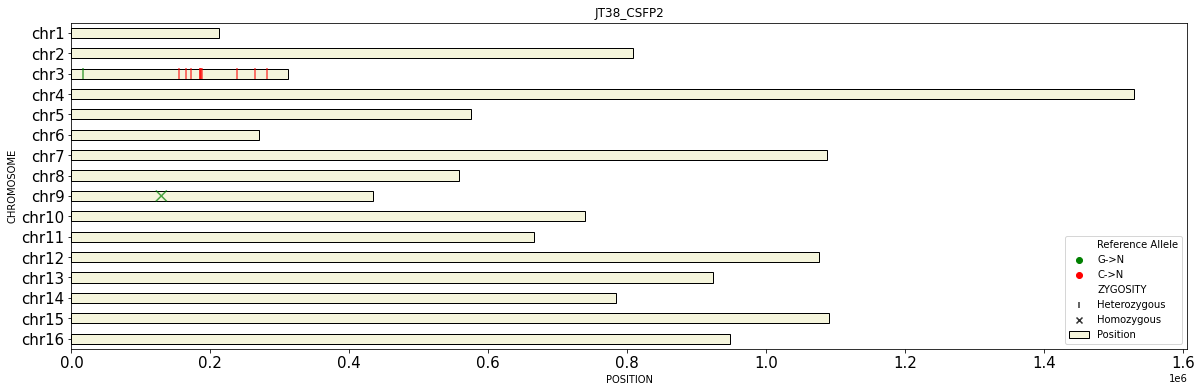

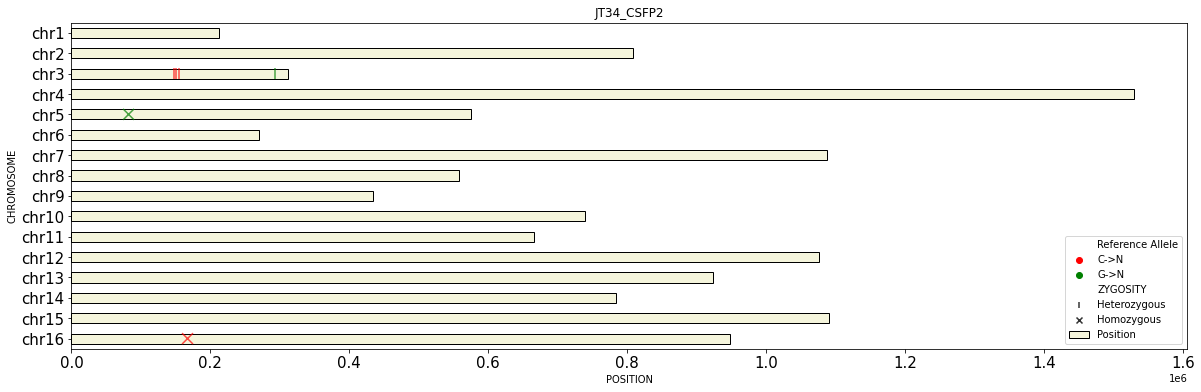

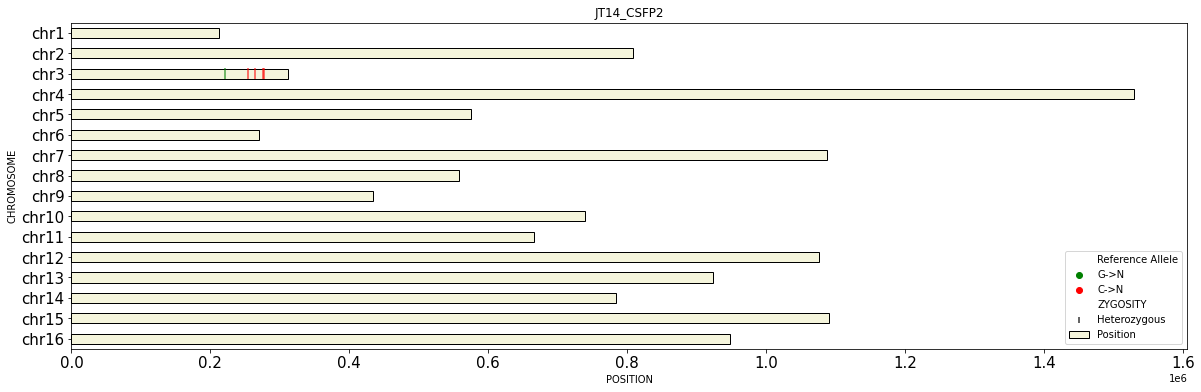

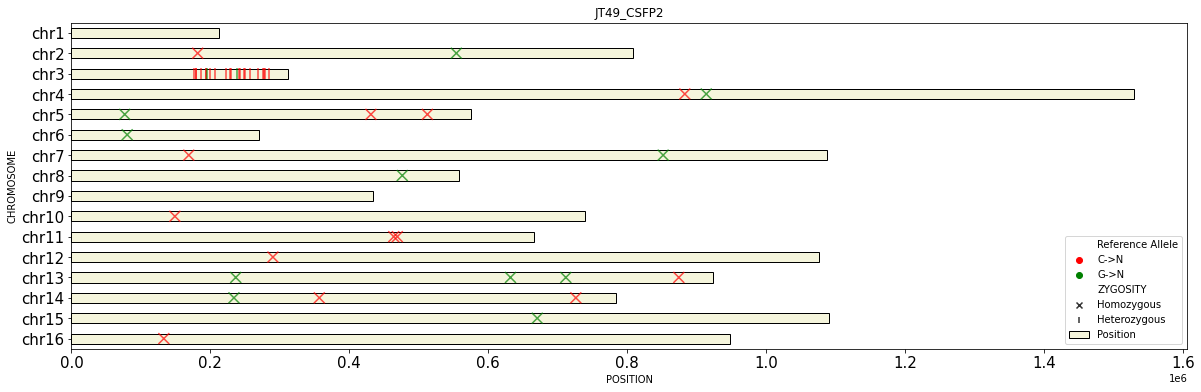

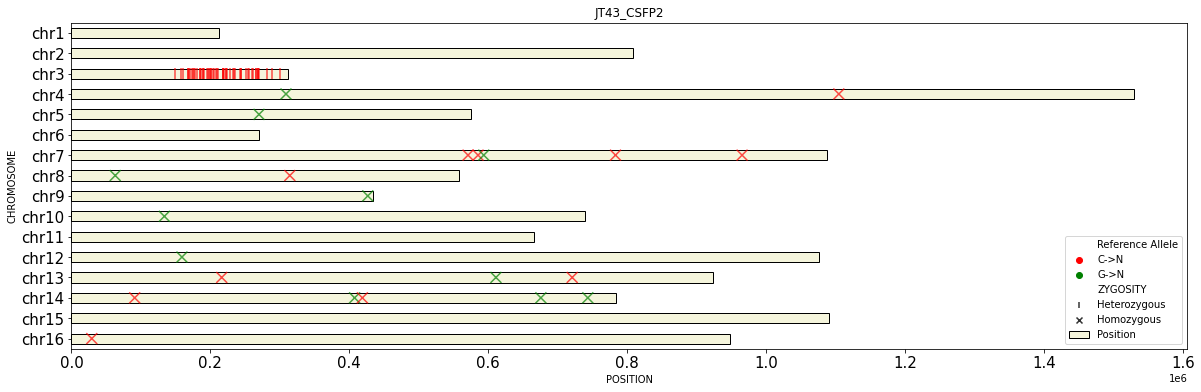

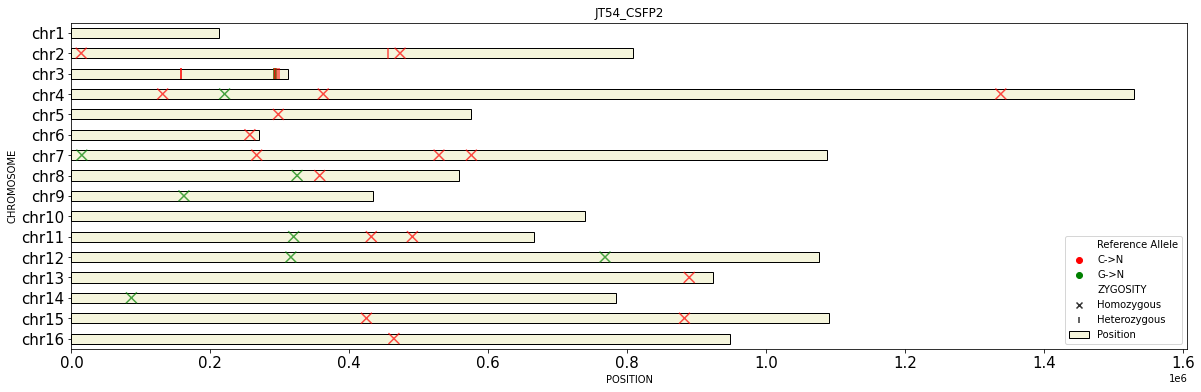

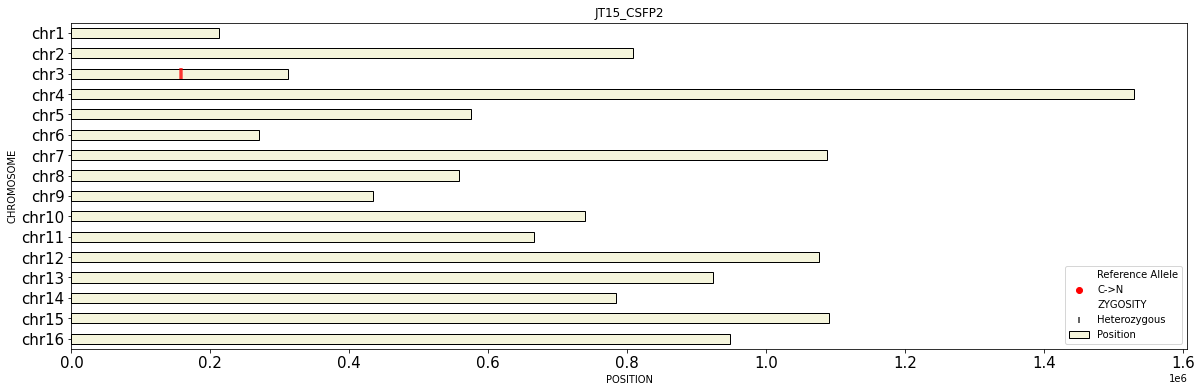

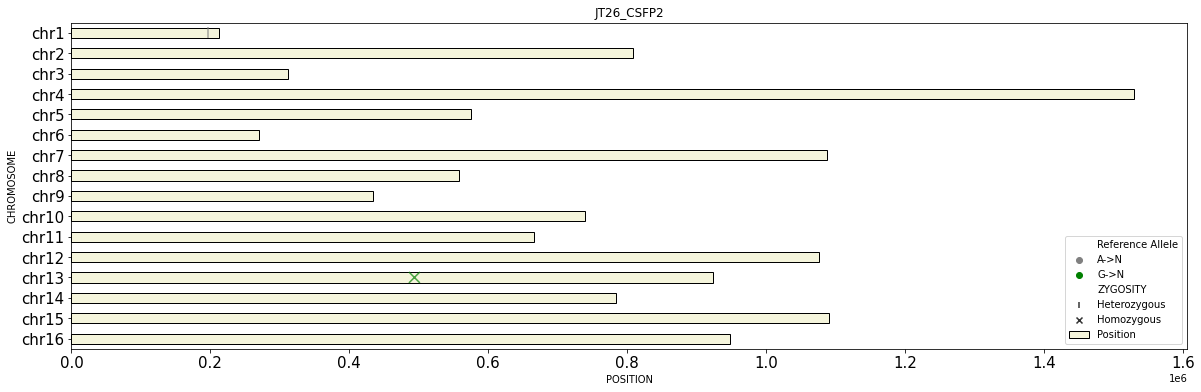

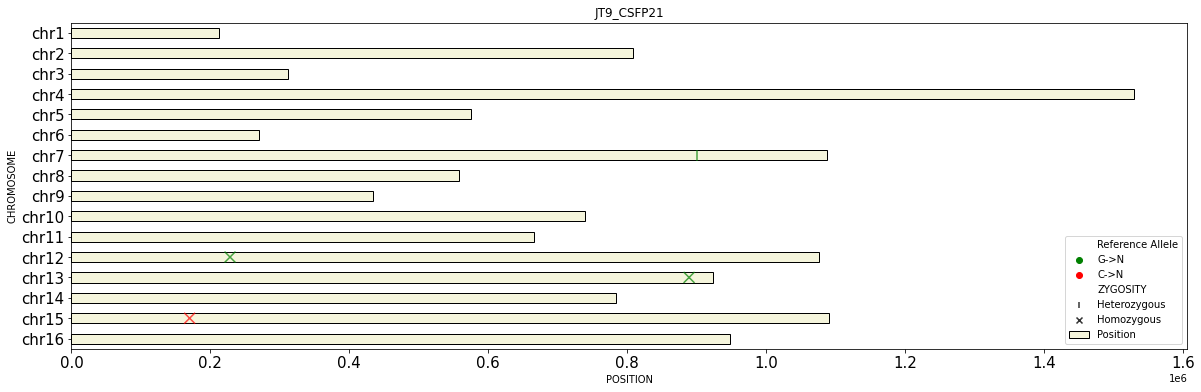

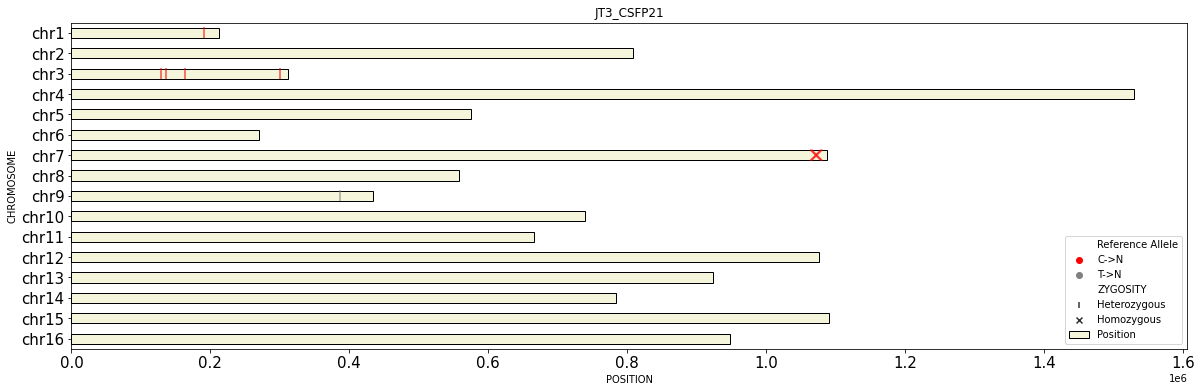

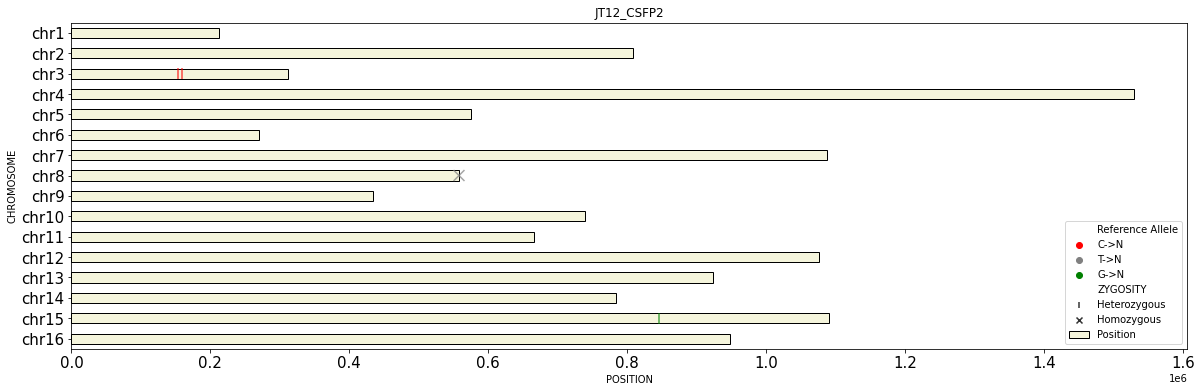

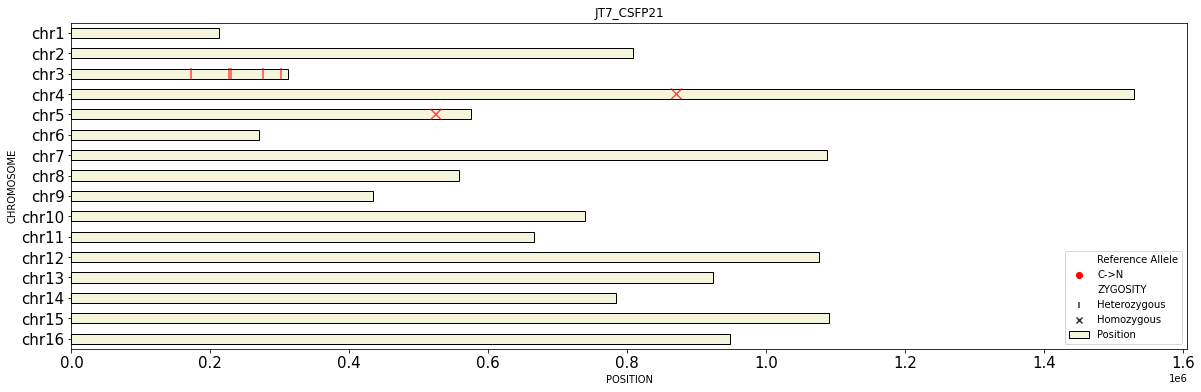

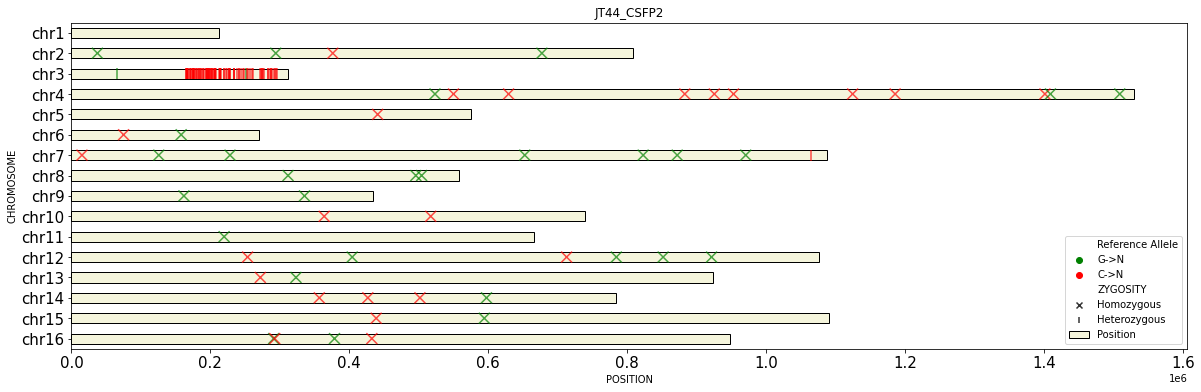

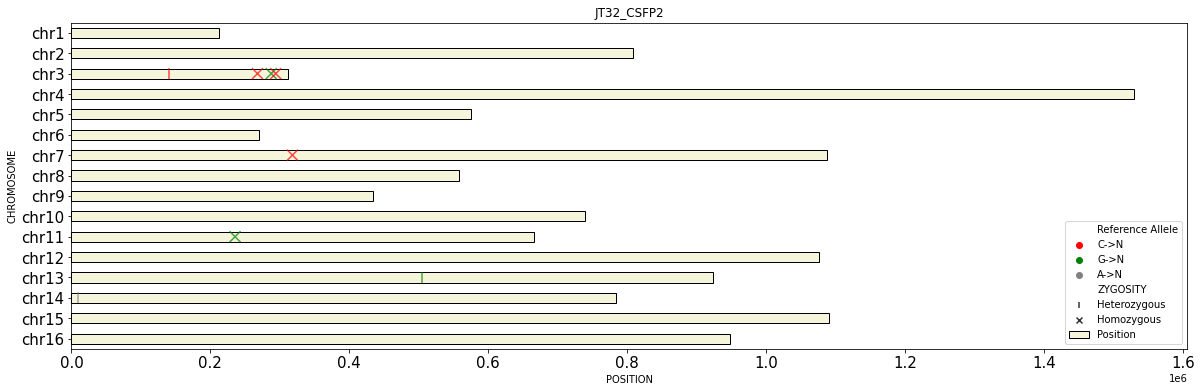

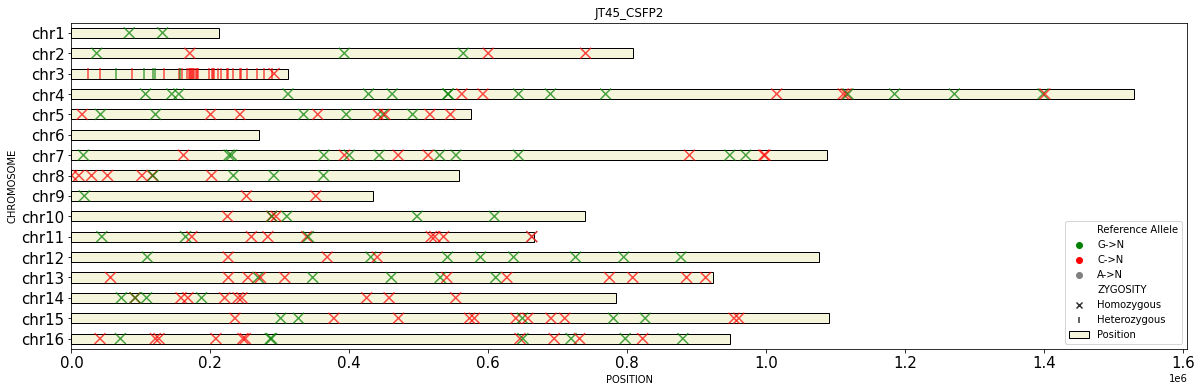

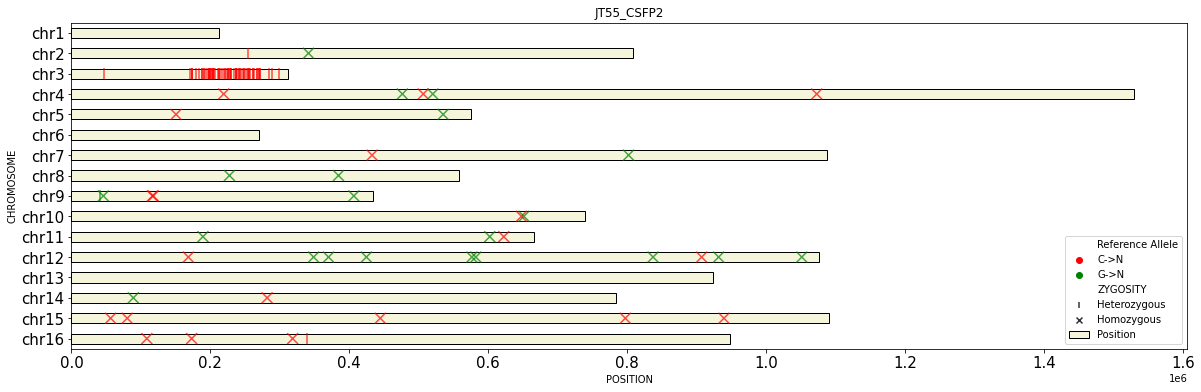

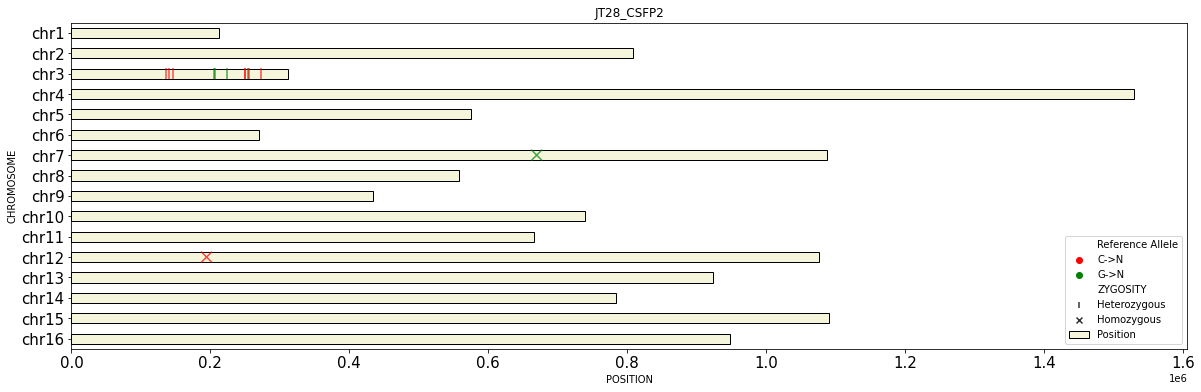

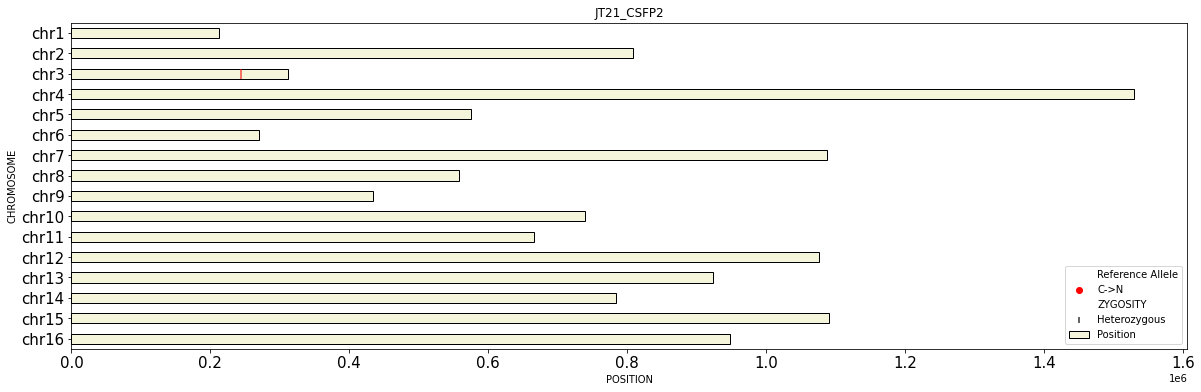

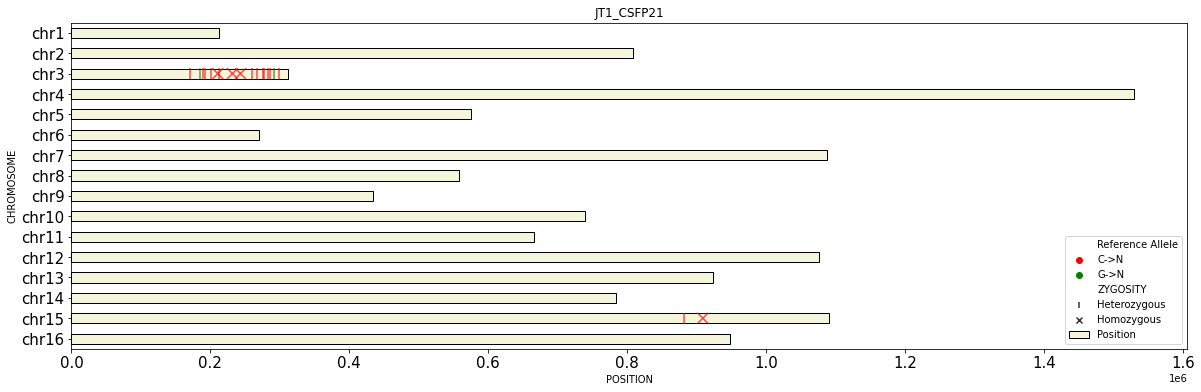

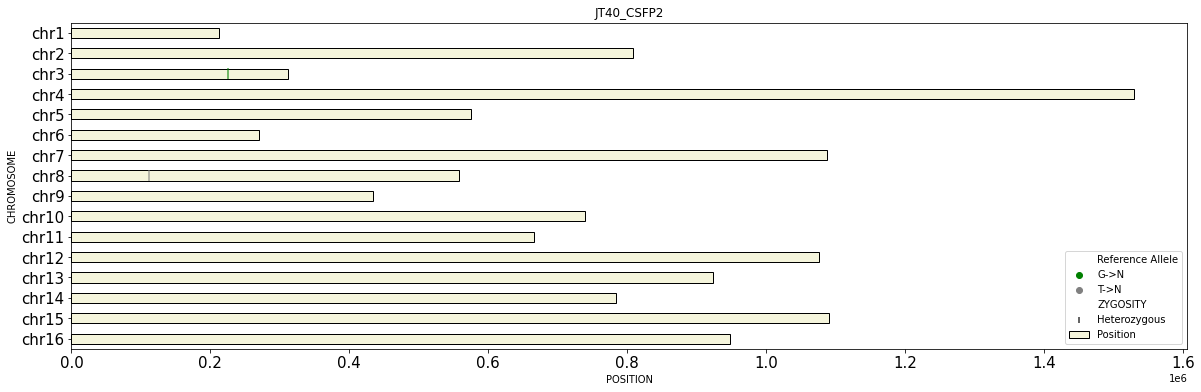

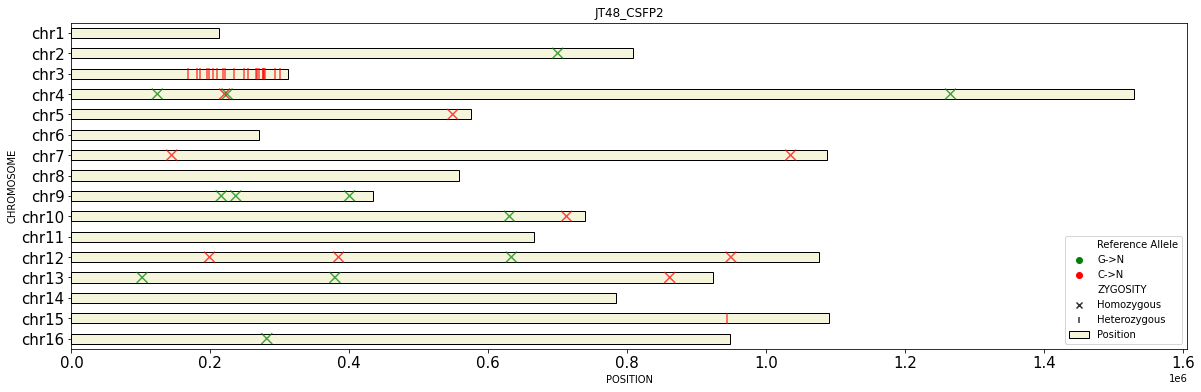

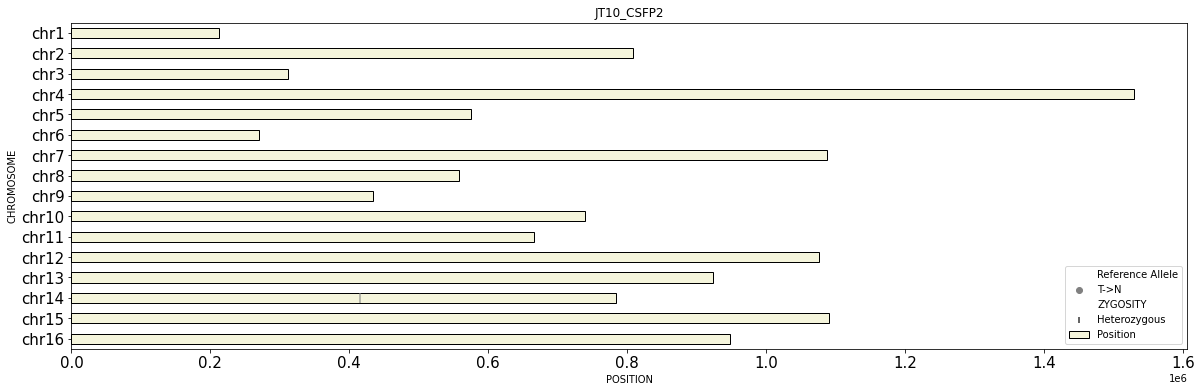

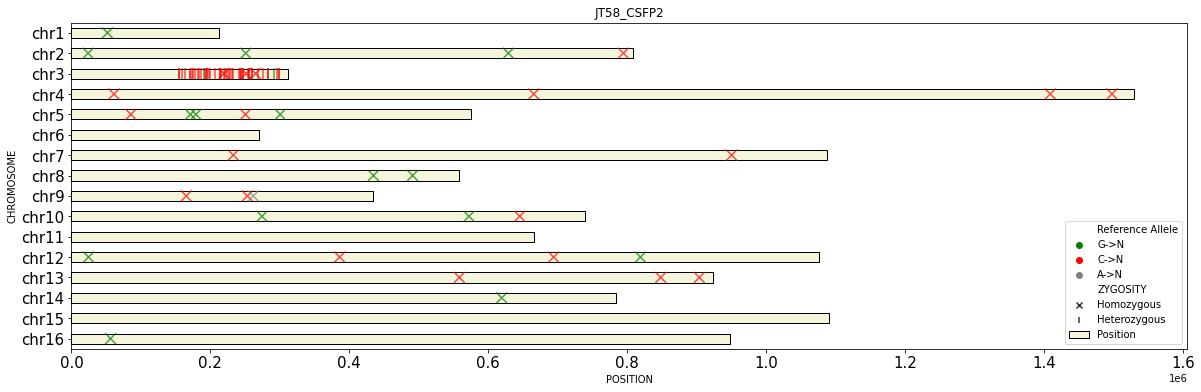

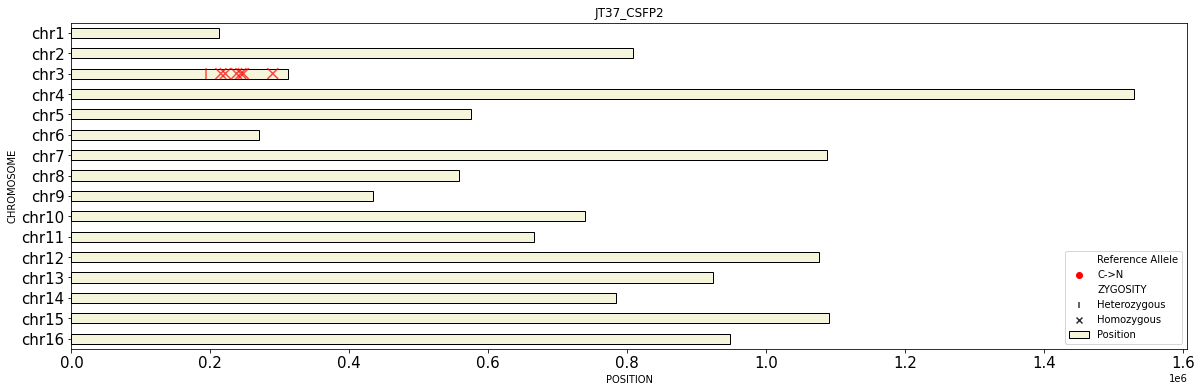

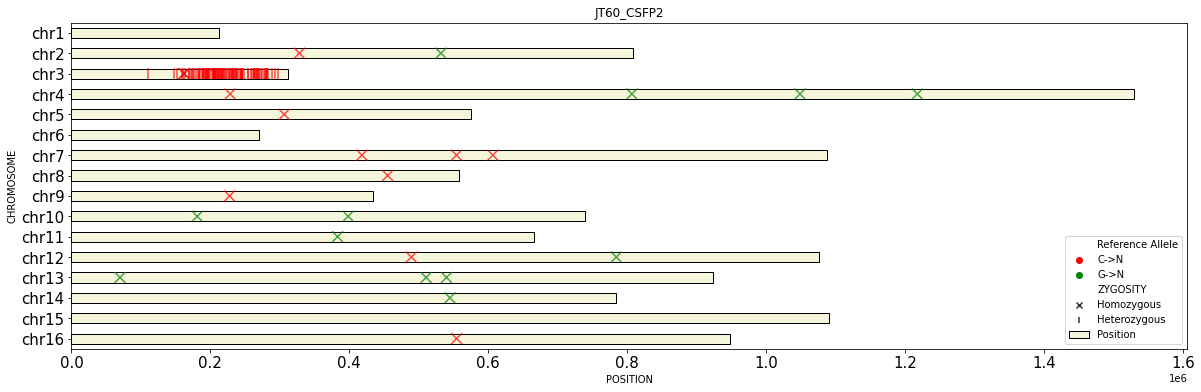

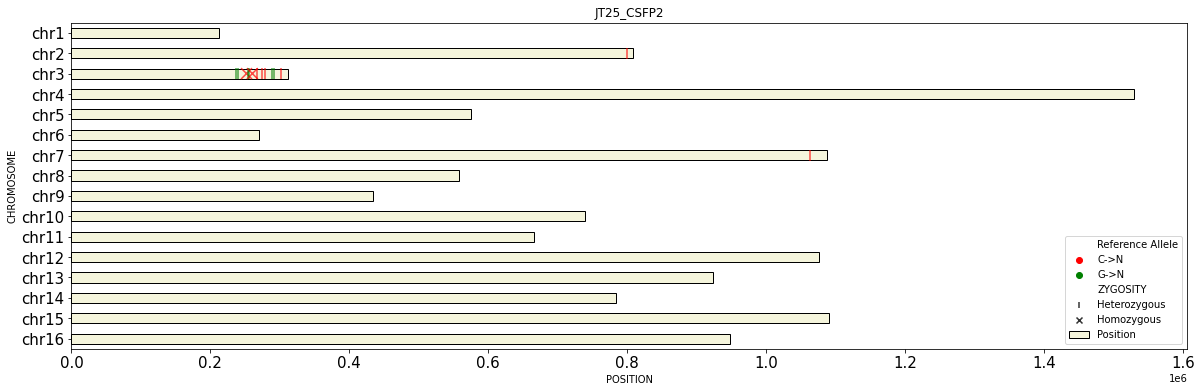

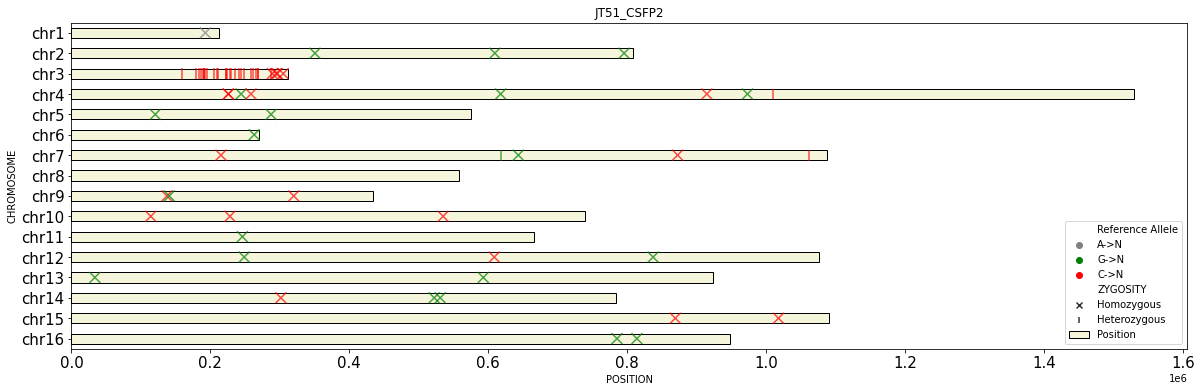

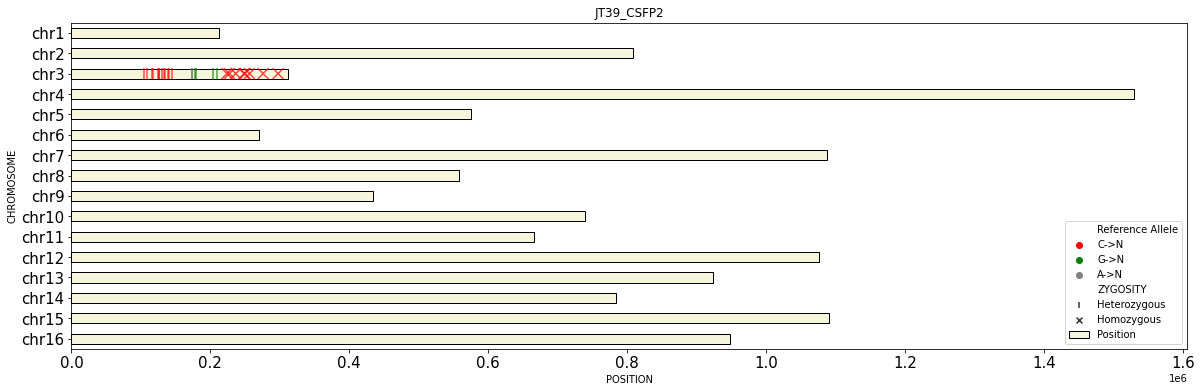

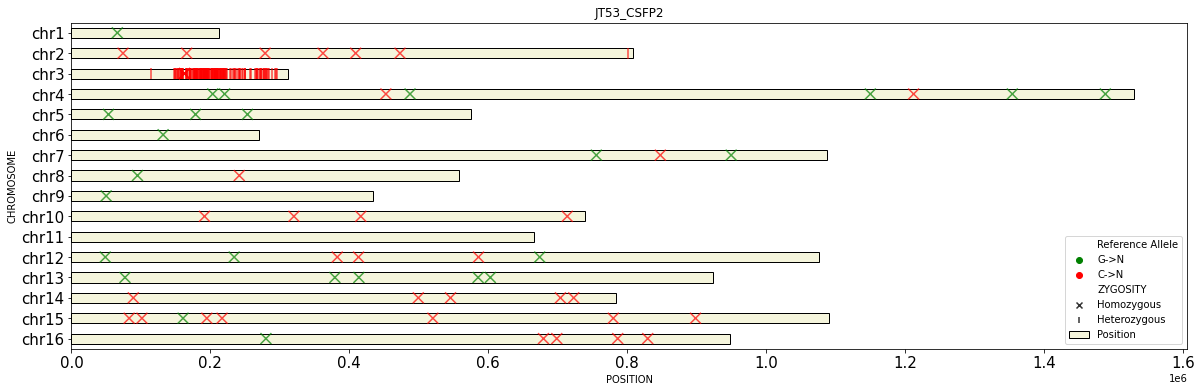

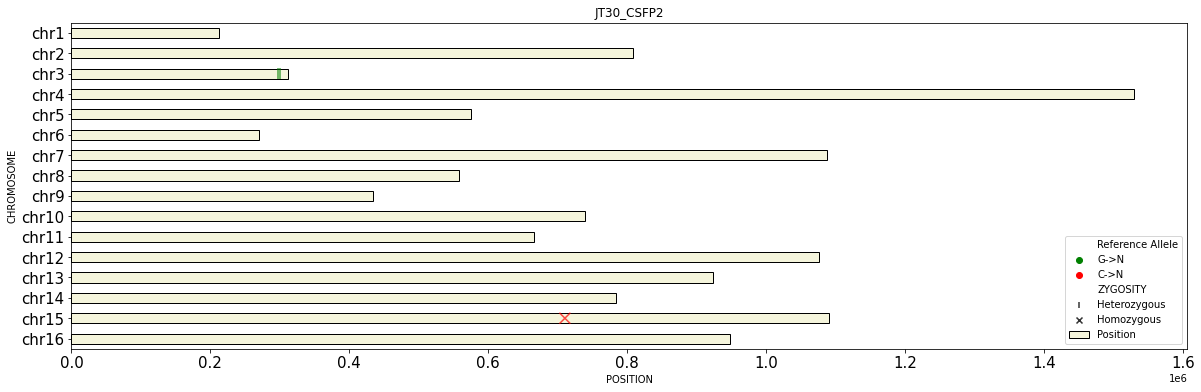

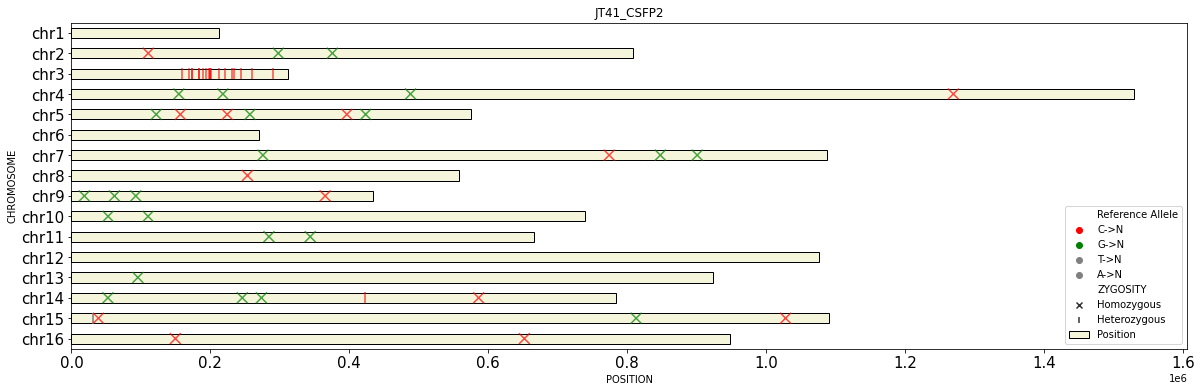

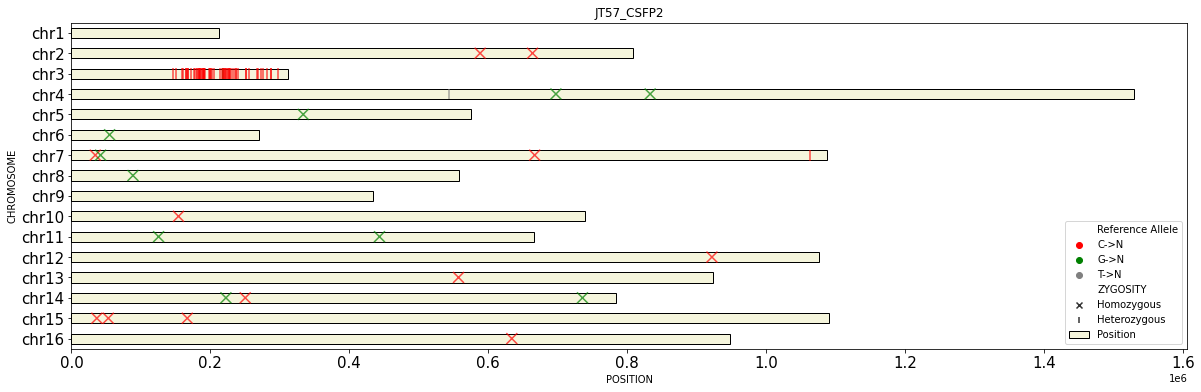

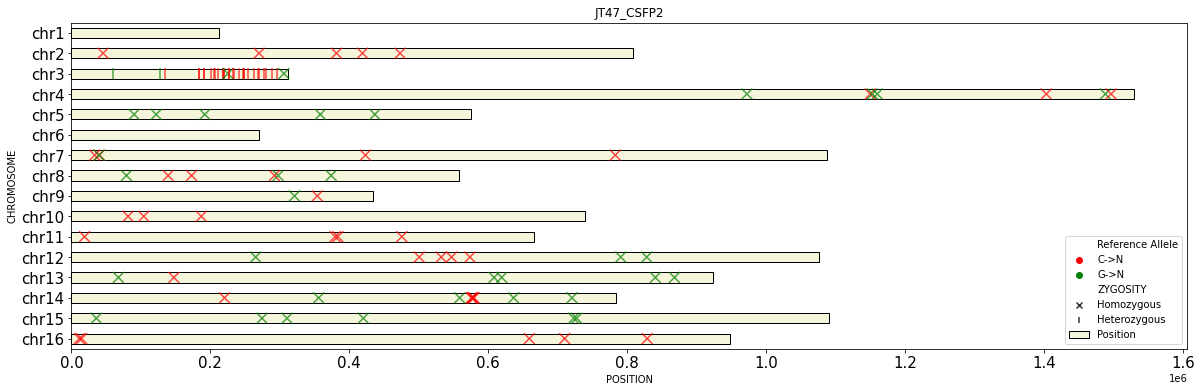

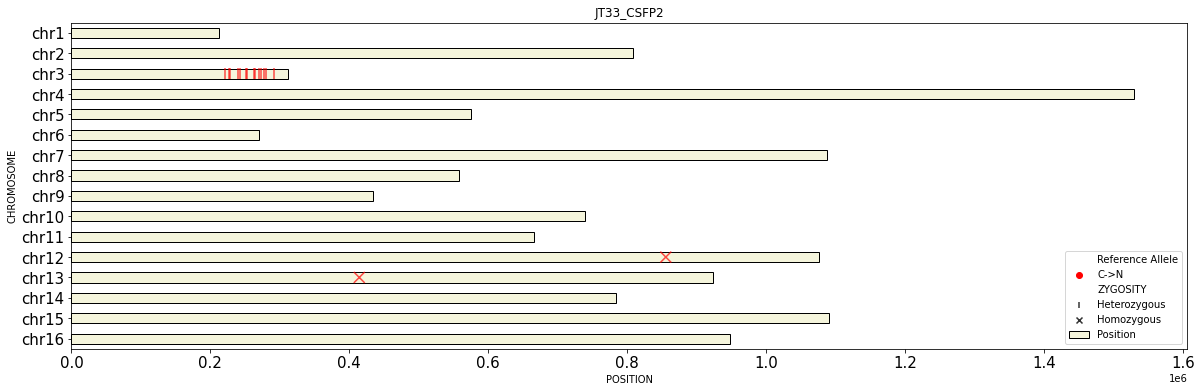

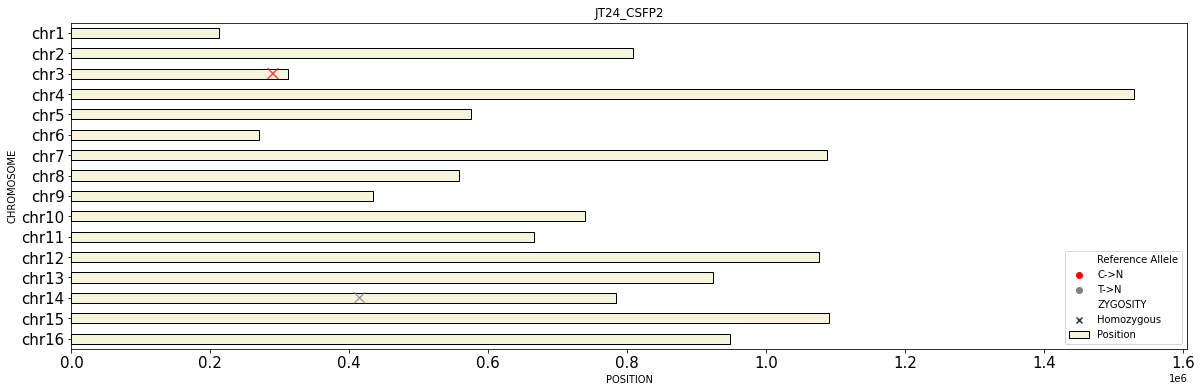

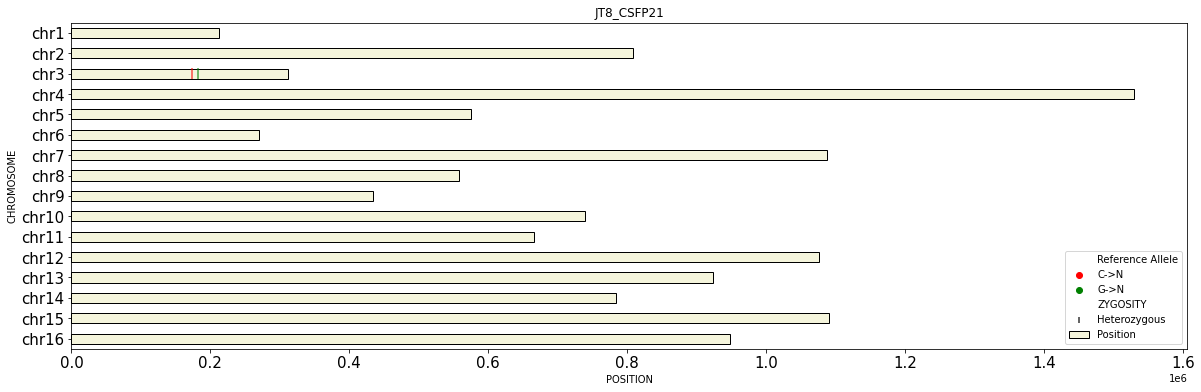

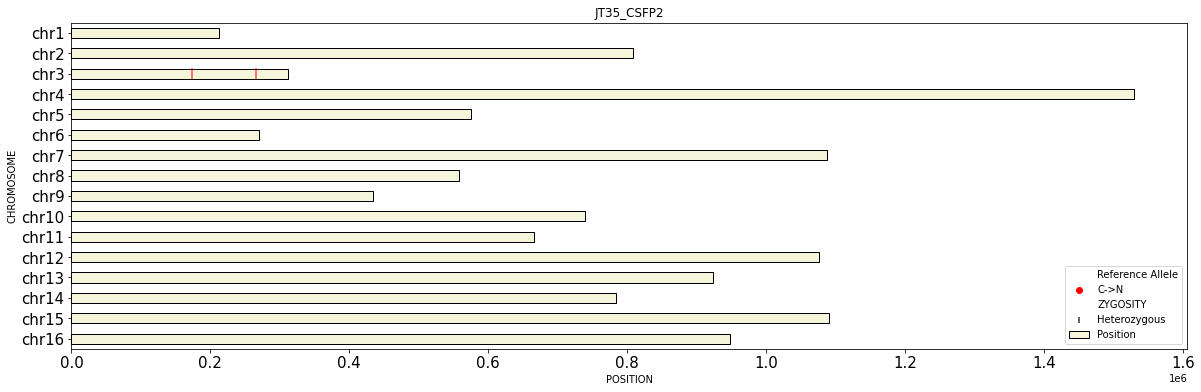

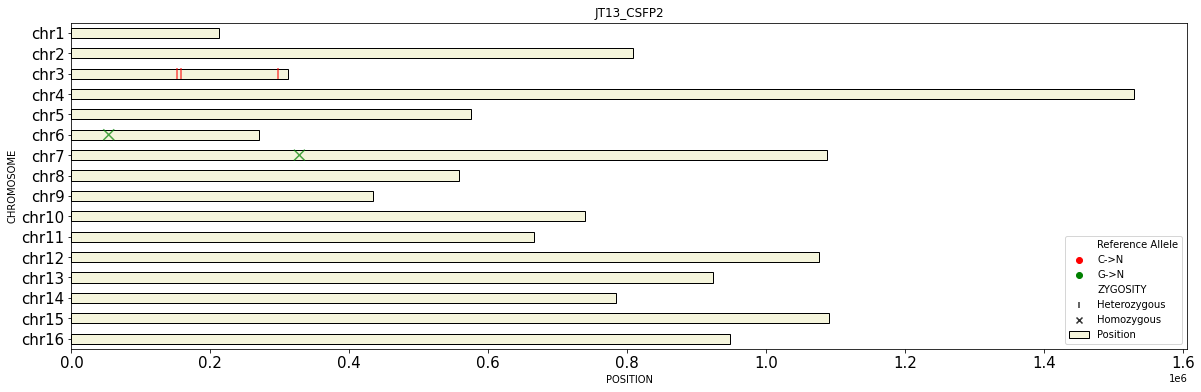

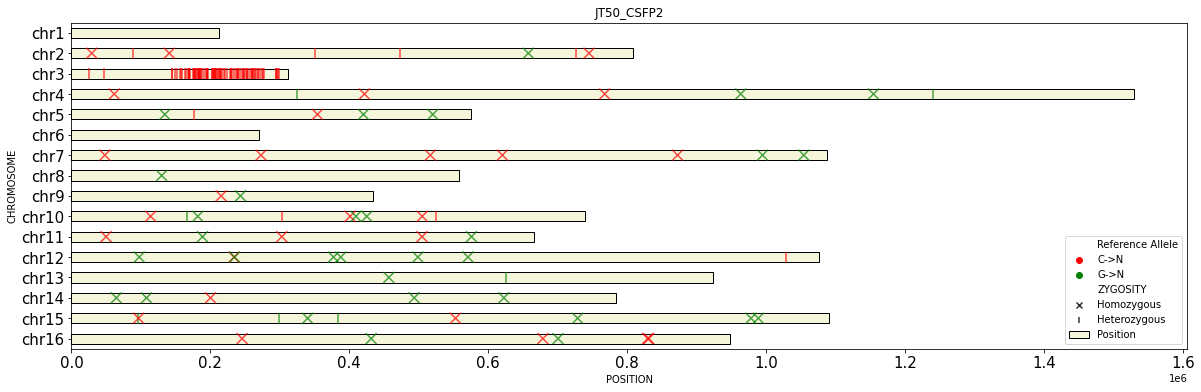

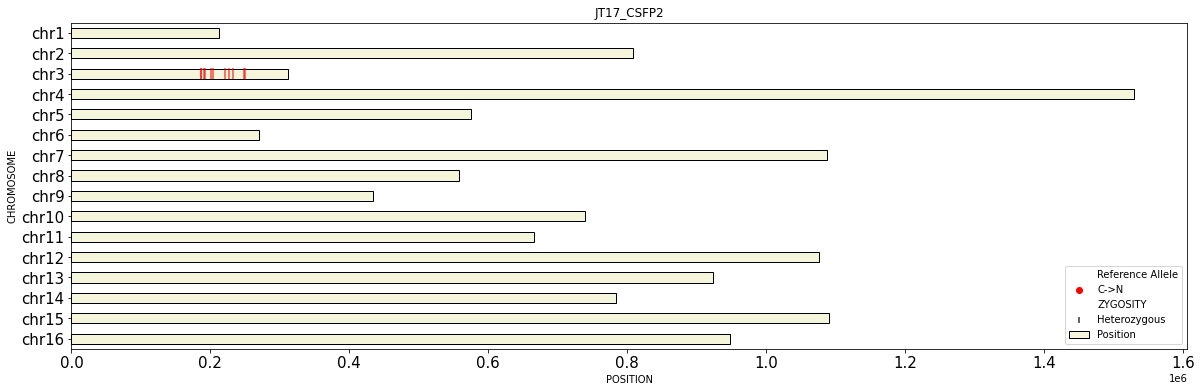

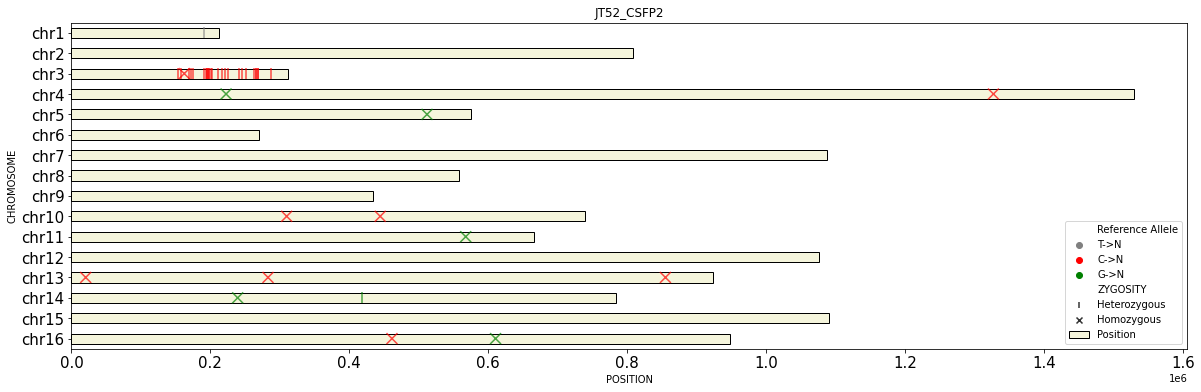

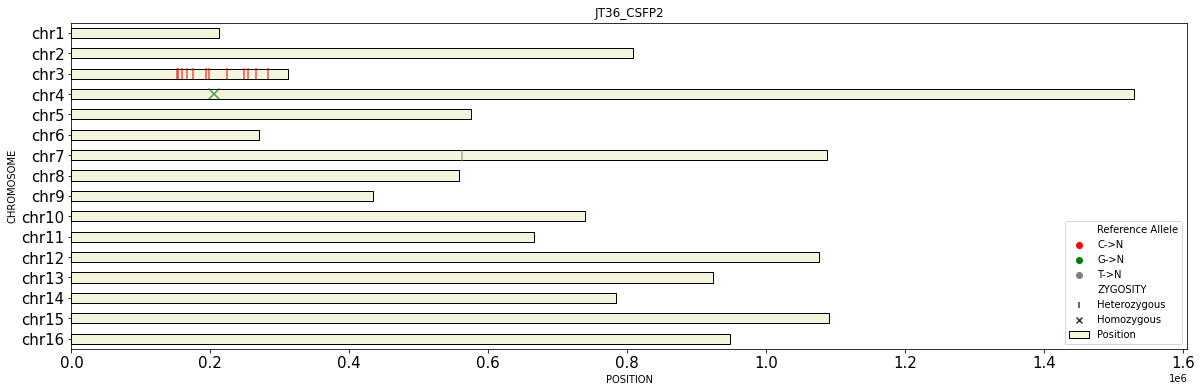

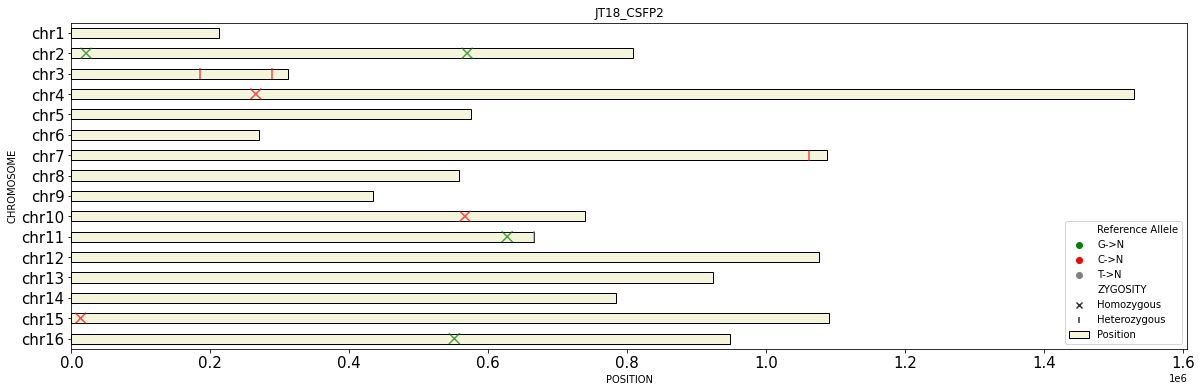

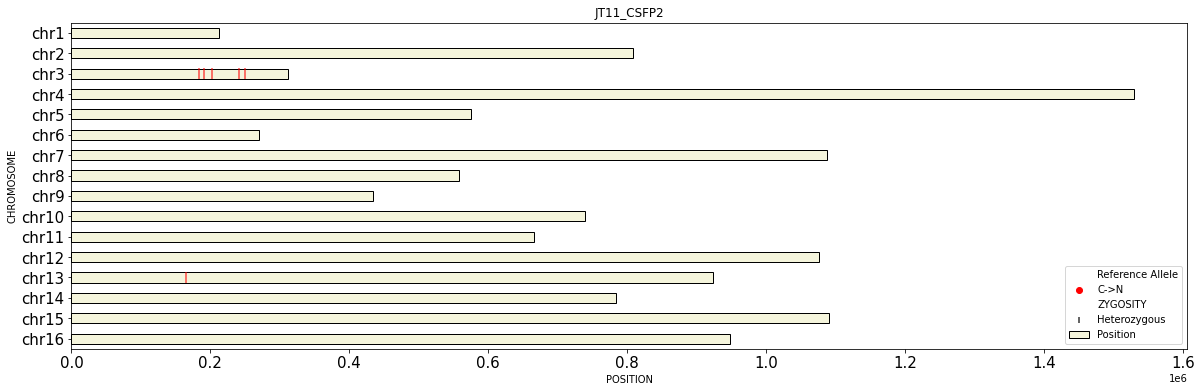

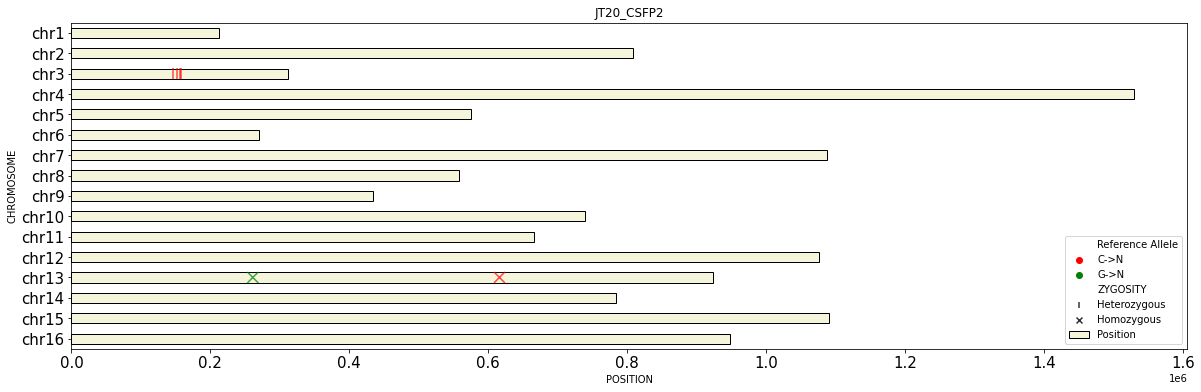

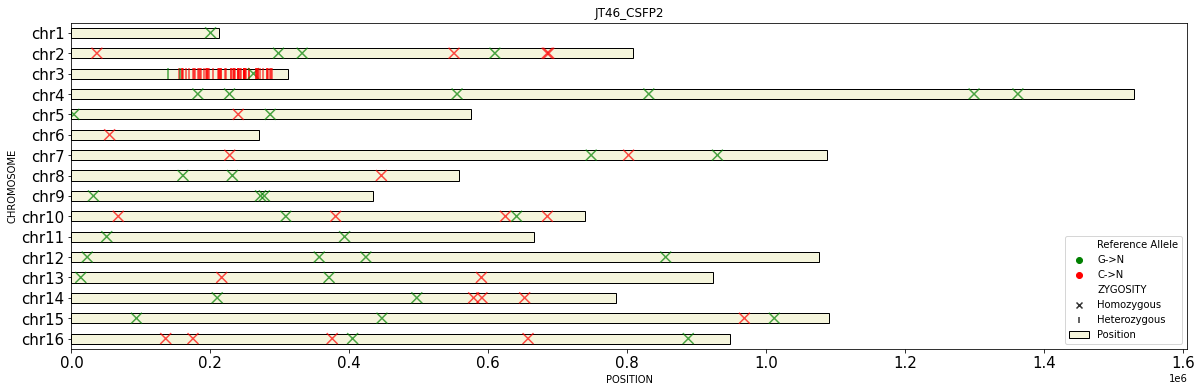

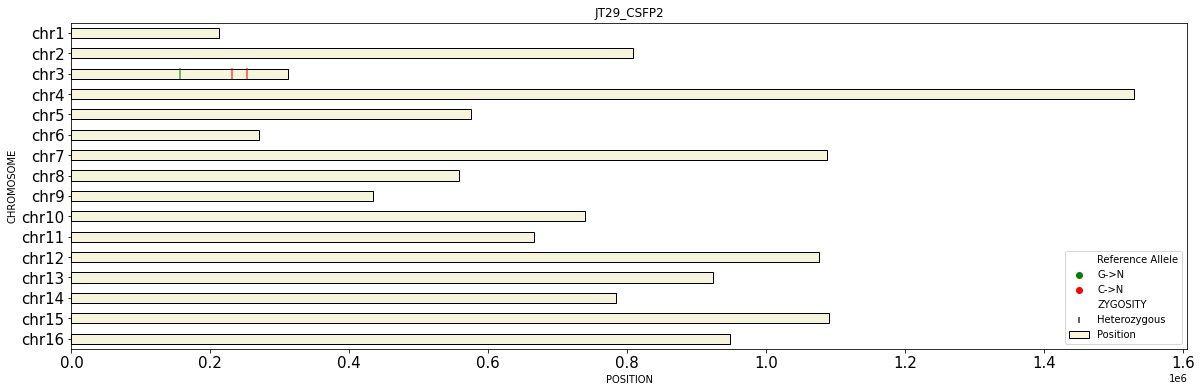

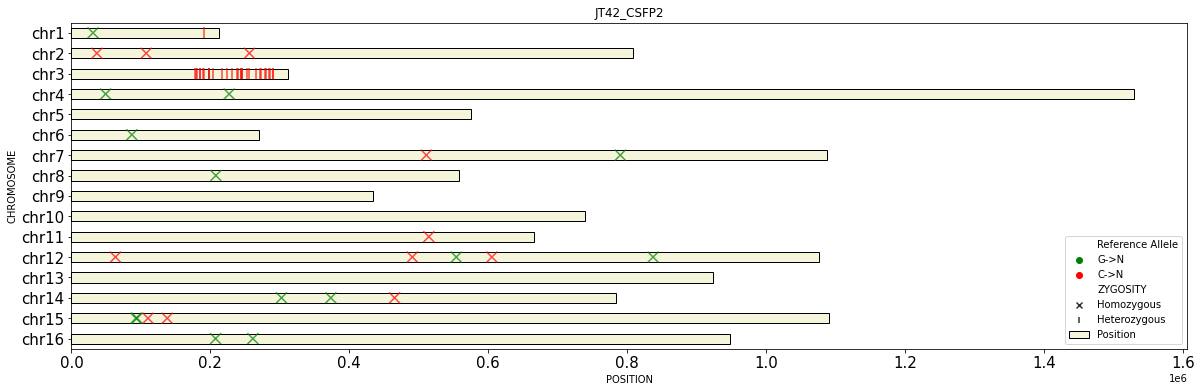

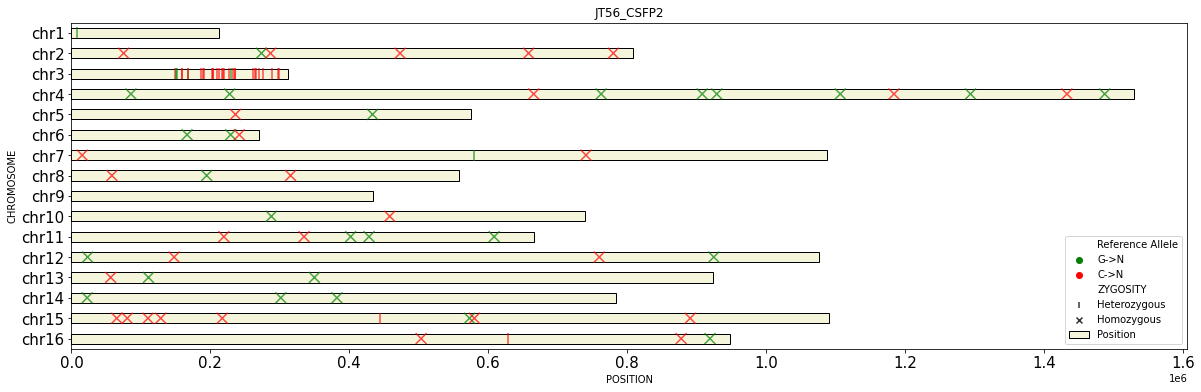

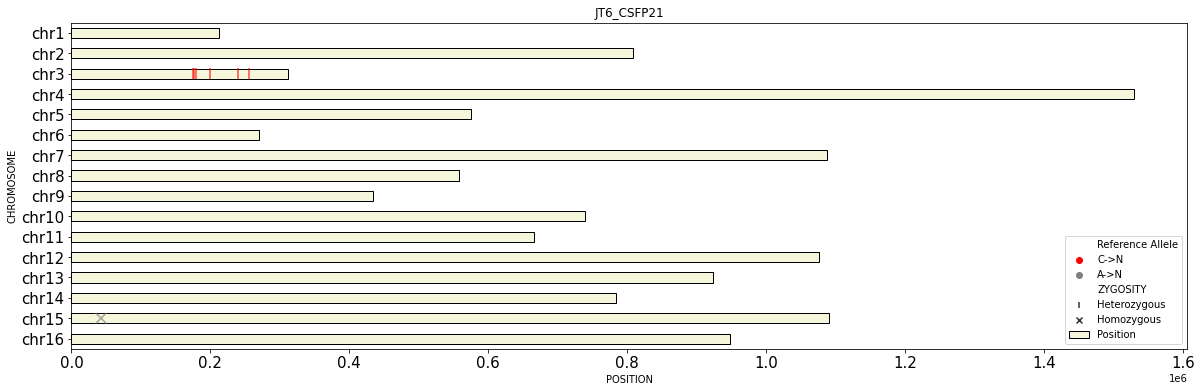

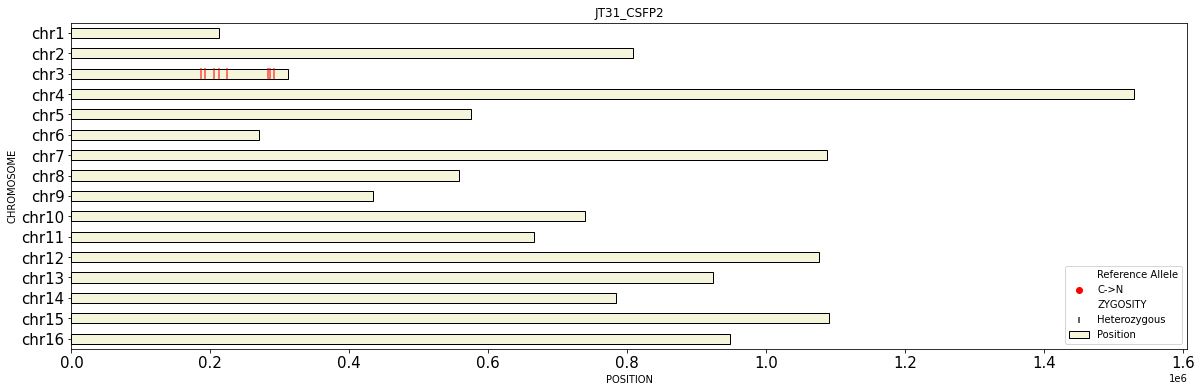

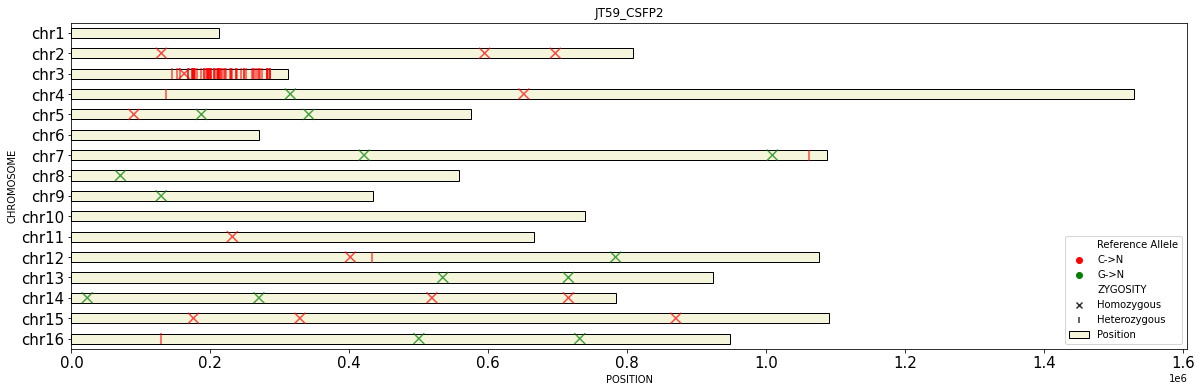

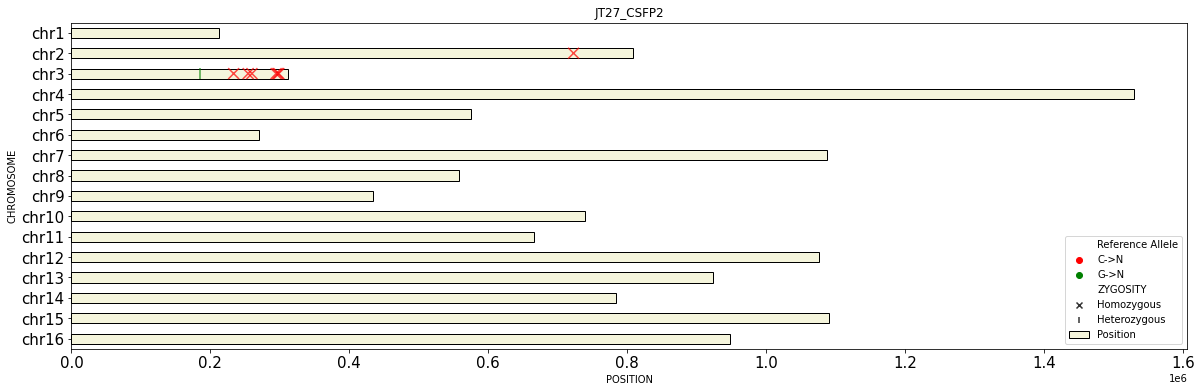

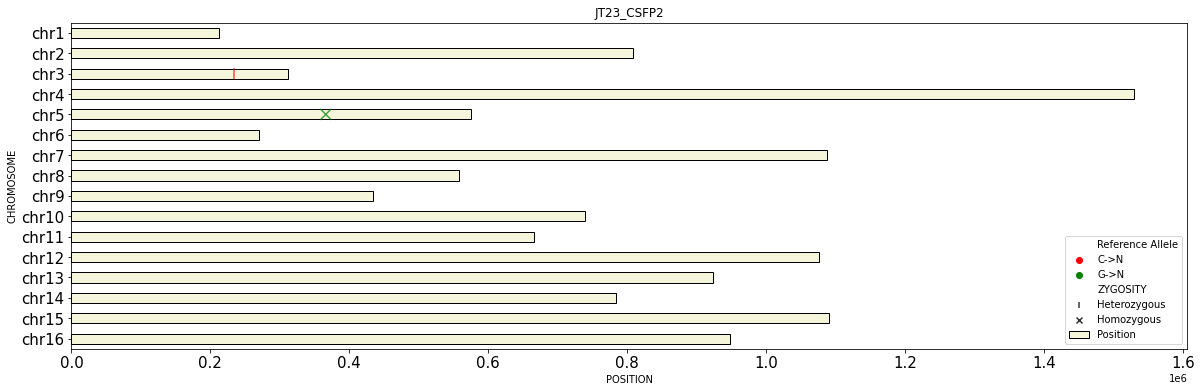

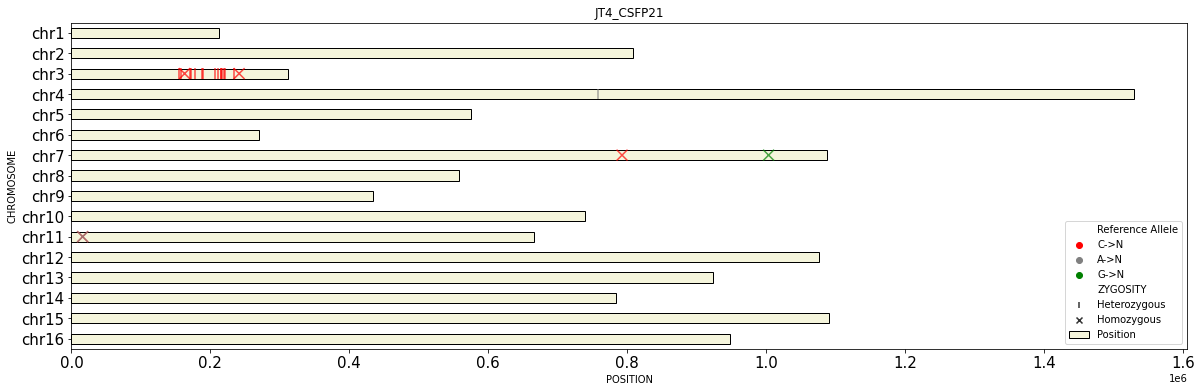

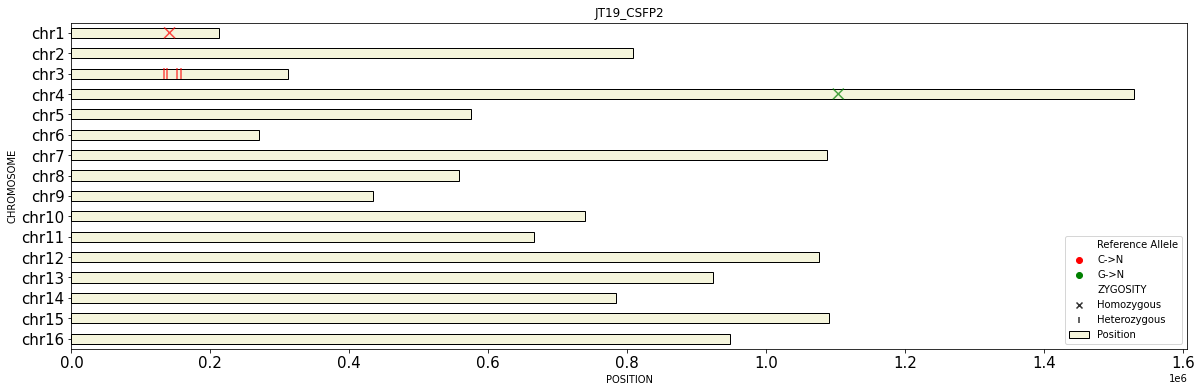

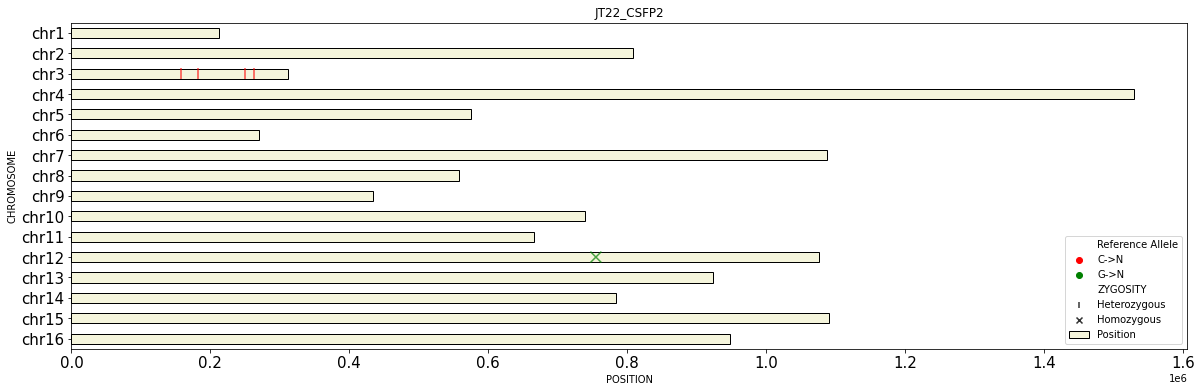

In [18]:
counter=0
for pd_df in subtracted_df_list: #frames_list #subtracted_df_list

  frame = pd_df.copy()
  
  #uncomment the line below for just G->N and C->N
  #frame = frame[frame['REF'].isin(['G','C'])]

  #uncomment the line below for just chr3 (can change to other chr as well)
  #frame = frame[frame["CHROM"] == "chr3"]

  #uncomment the line below for just right arm of chr3 (or any other position)
  #frame = frame[frame['POS'] > 114501]

  #uncomment line below for just G->N mutations
  #frame = frame[frame['REF'].isin(['G'])]

  #append dummy positions in case certain chromosomes are empty
  frame = frame.append(starts, ignore_index=True)
  print(sample_names[counter])
  print(frame)

  drawSNPMap(frame, df_chr, starts, title=sample_names[counter], sample_names=sample_names)

  counter+=1

Count all occurences of each type of mutation and display and save the resulting summary table for each DF. Notes:
- can also set grouping settings to REF/ALT which won't draw figures but will still create a summary output file.
- mutation spectra are irrespective of strand coordination

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


    Sample  REF  ALT Count SPECTRA
0     JT38  NaN  NaN     5  C_to_G
1     JT38  NaN  NaN     7  C_to_T
2     JT34  NaN  NaN     3  C_to_G
3     JT34  NaN  NaN     3  C_to_T
4     JT14  NaN  NaN     2  C_to_G
..     ...  ...  ...   ...     ...
114    JT4  NaN  NaN     1  T_to_C
115   JT19  NaN  NaN     2  C_to_A
116   JT19  NaN  NaN     4  C_to_T
117   JT22  NaN  NaN     3  C_to_G
118   JT22  NaN  NaN     2  C_to_T

[119 rows x 5 columns]


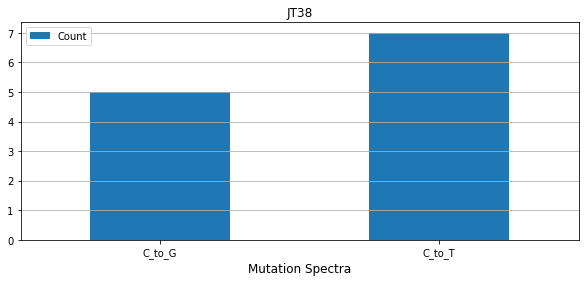

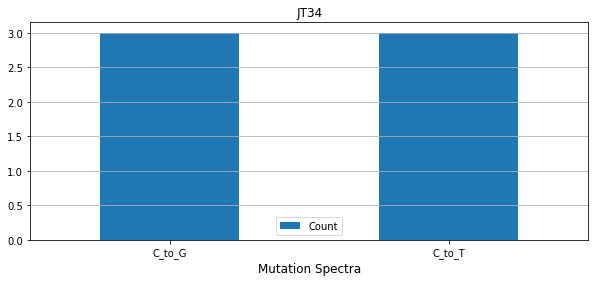

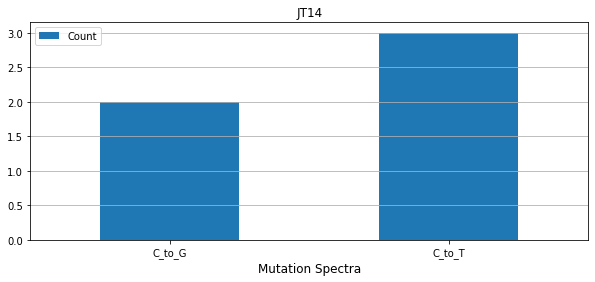

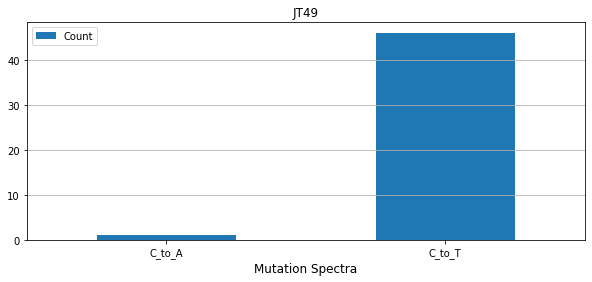

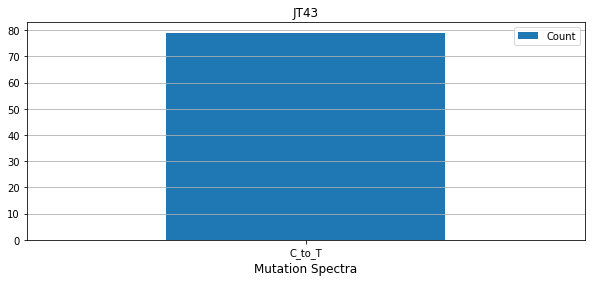

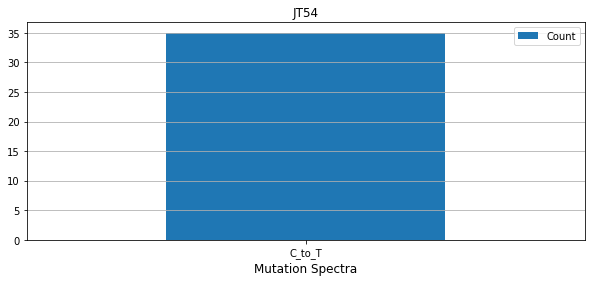

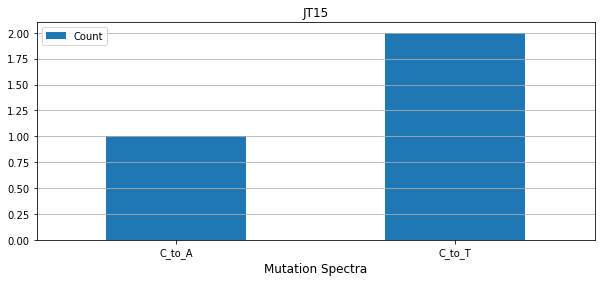

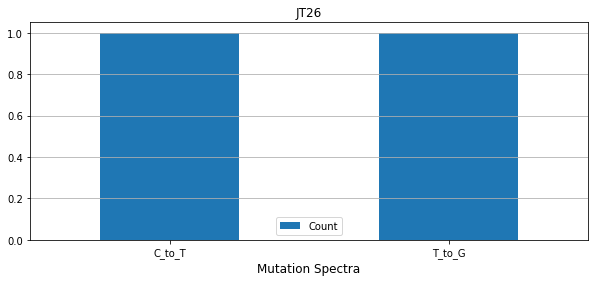

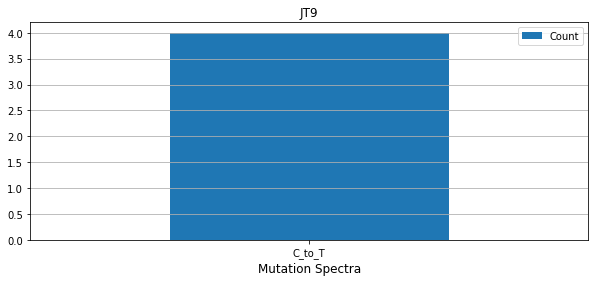

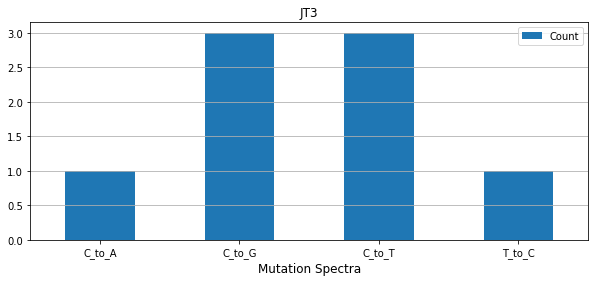

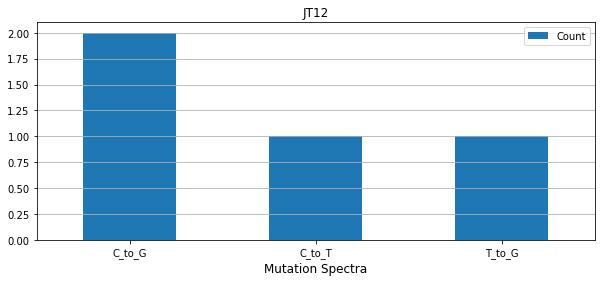

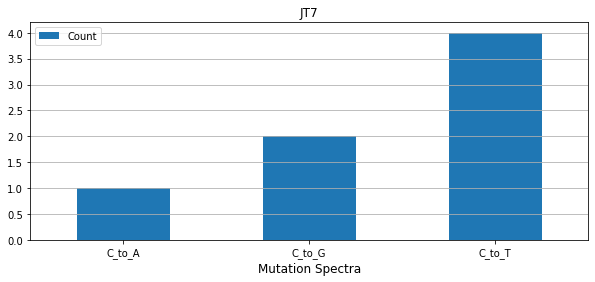

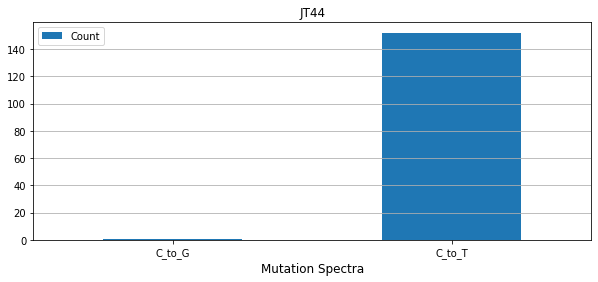

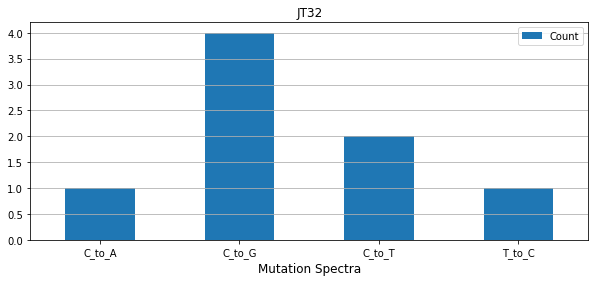

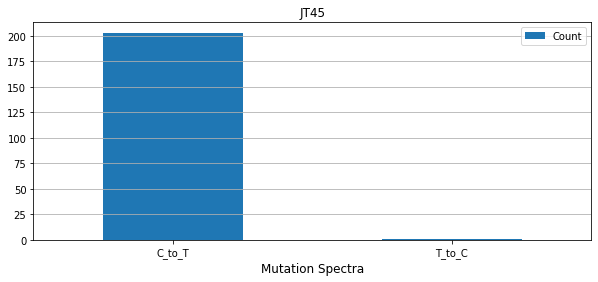

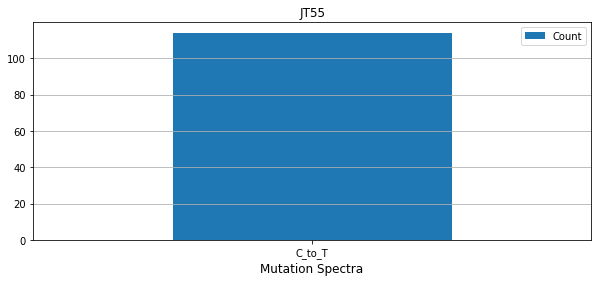

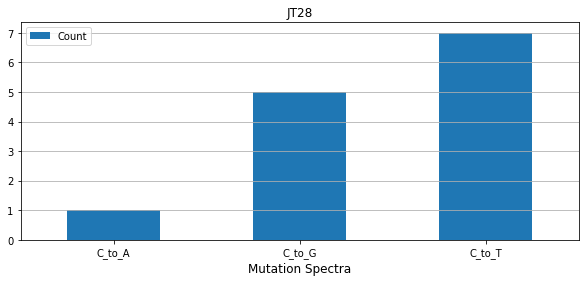

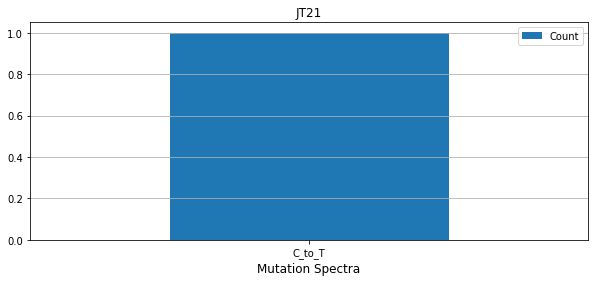

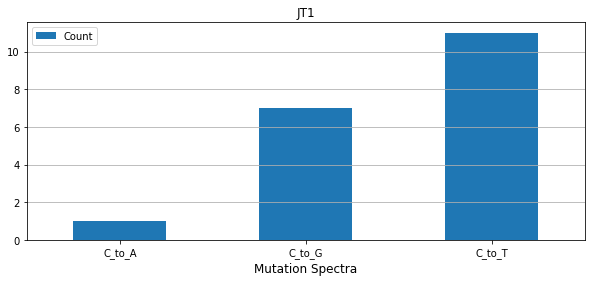

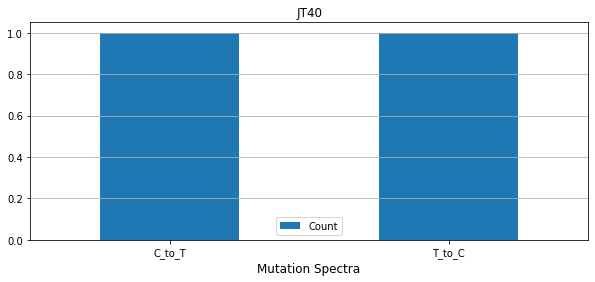

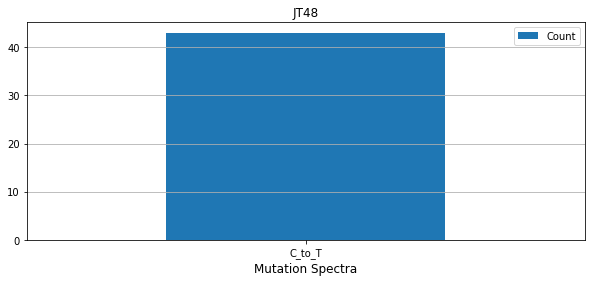

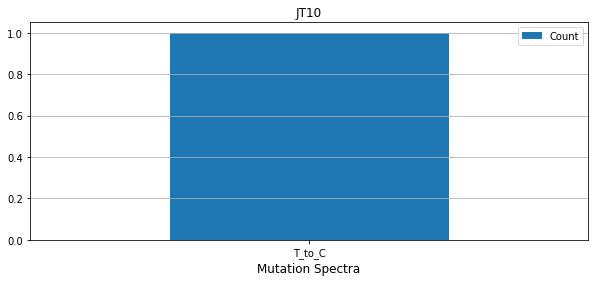

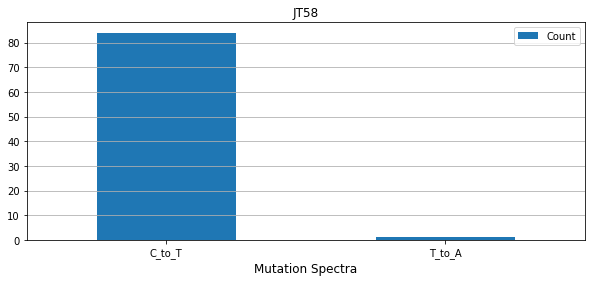

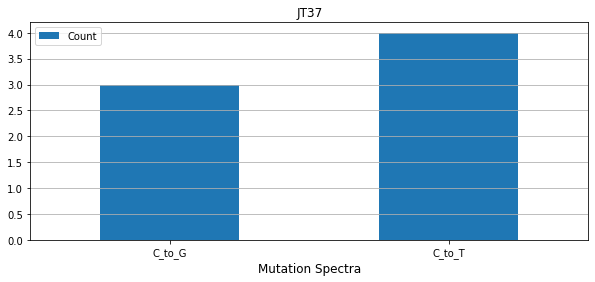

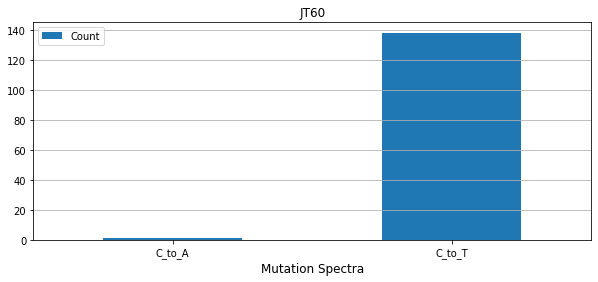

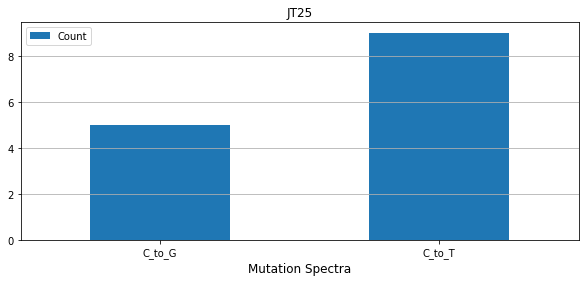

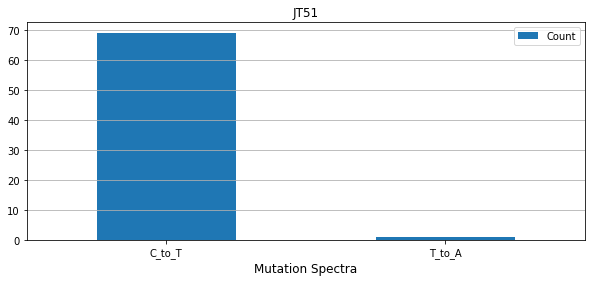

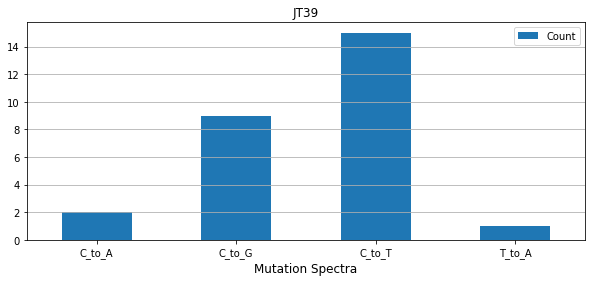

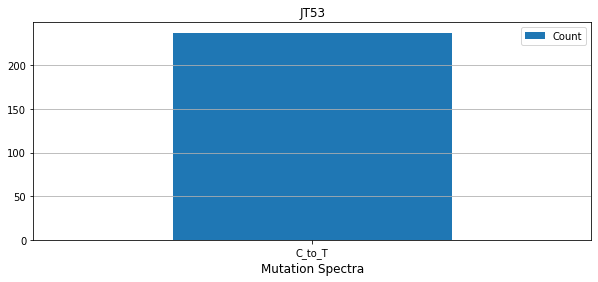

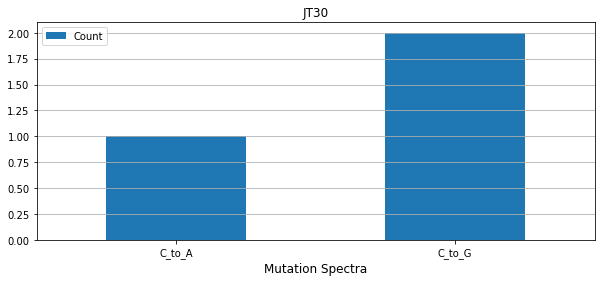

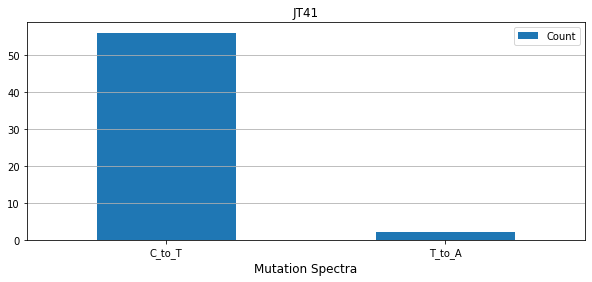

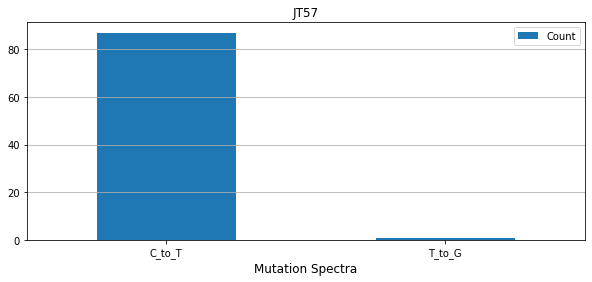

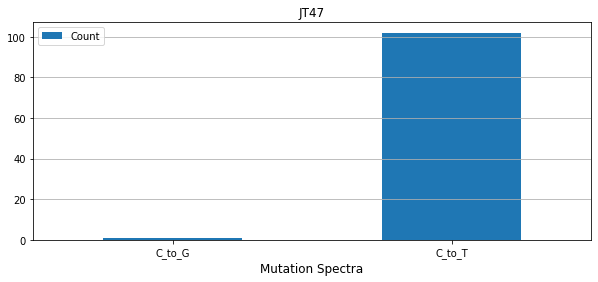

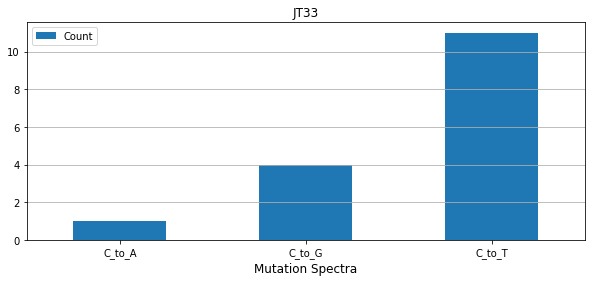

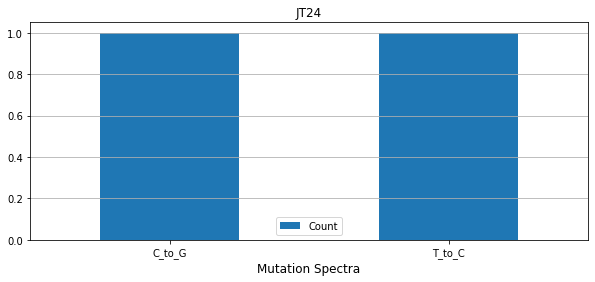

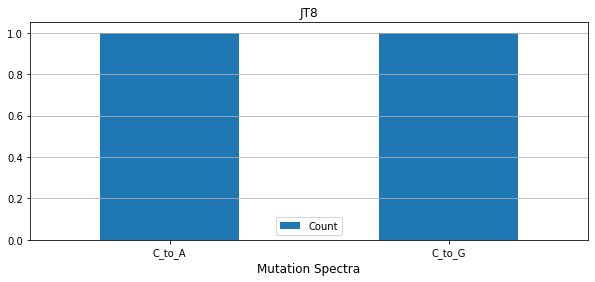

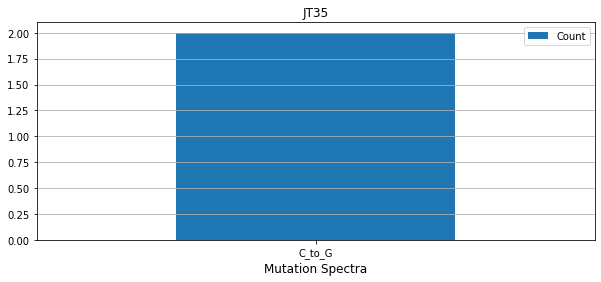

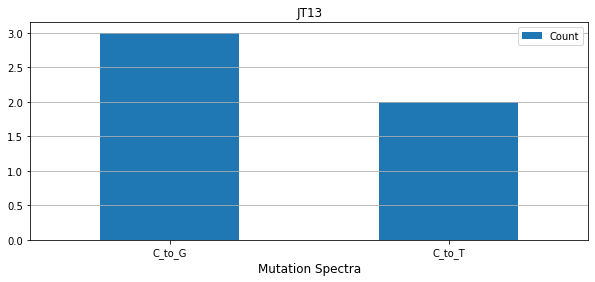

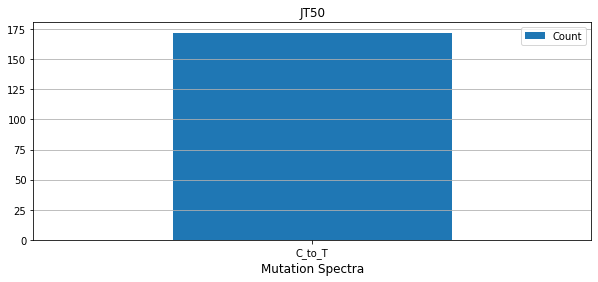

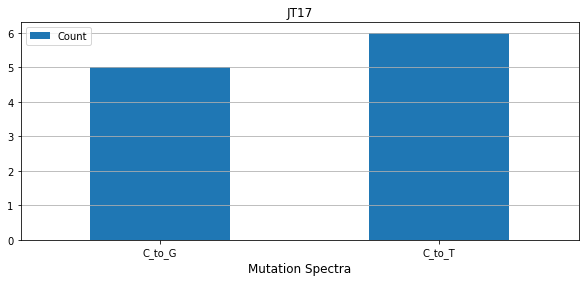

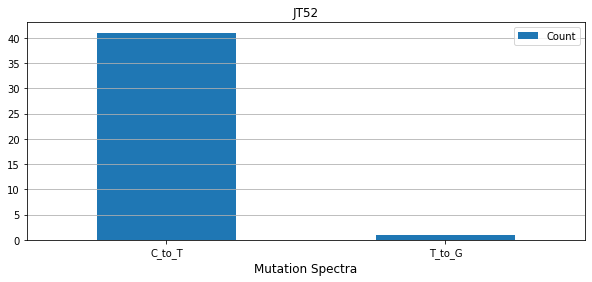

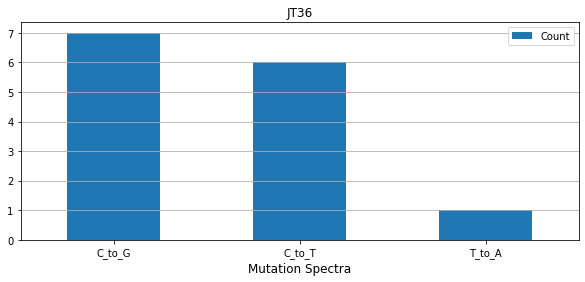

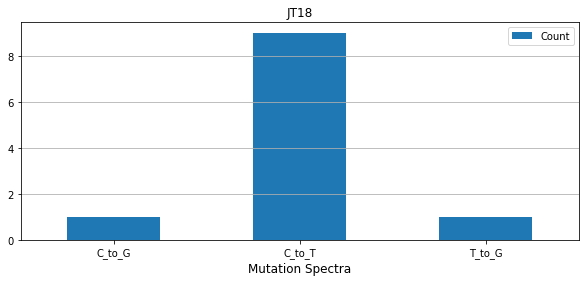

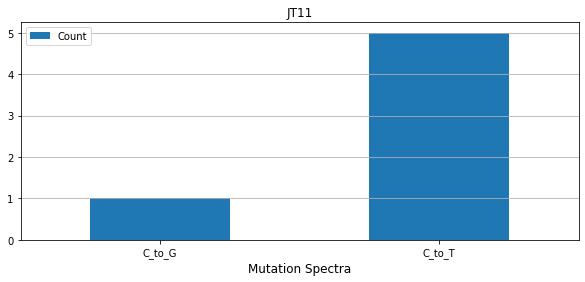

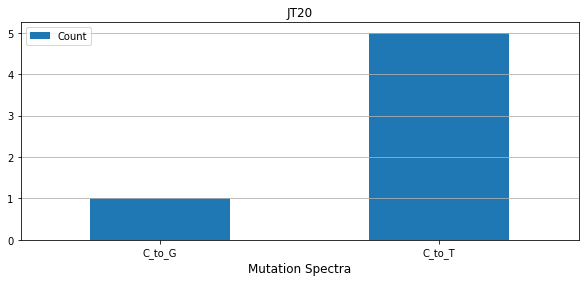

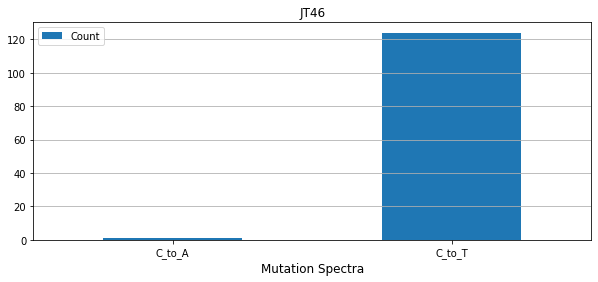

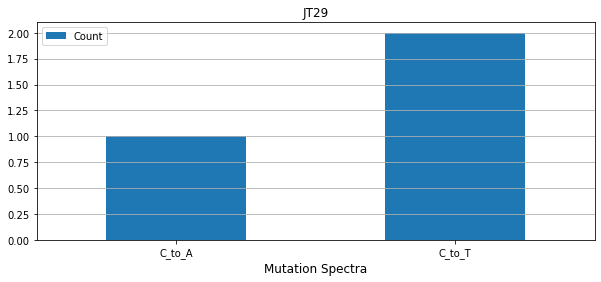

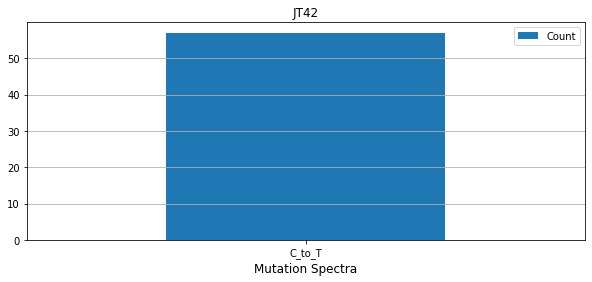

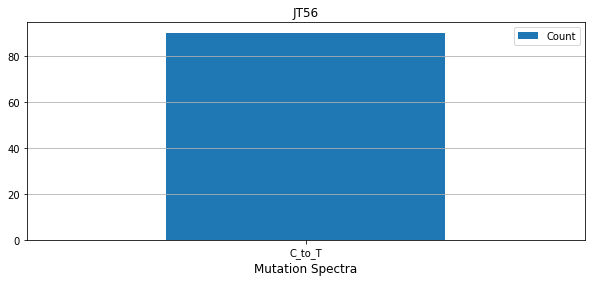

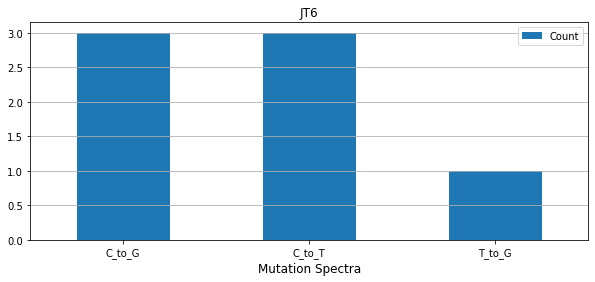

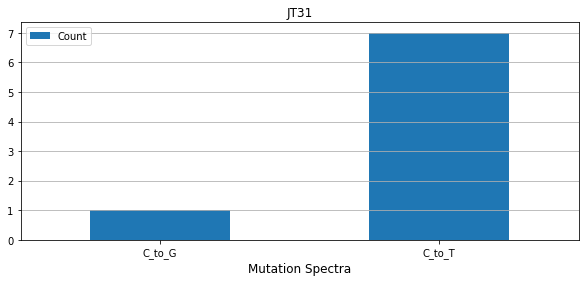

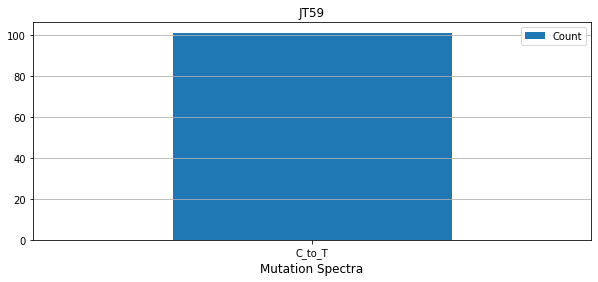

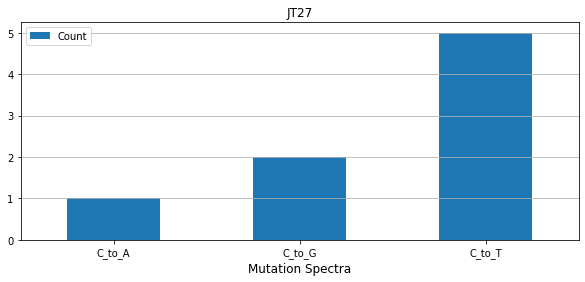

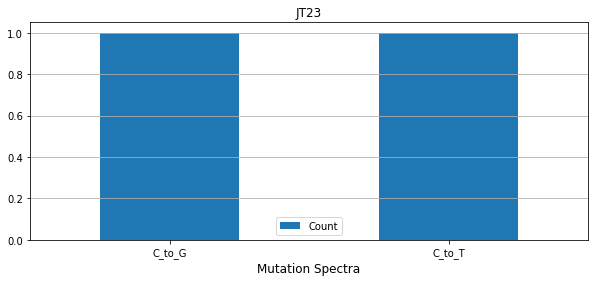

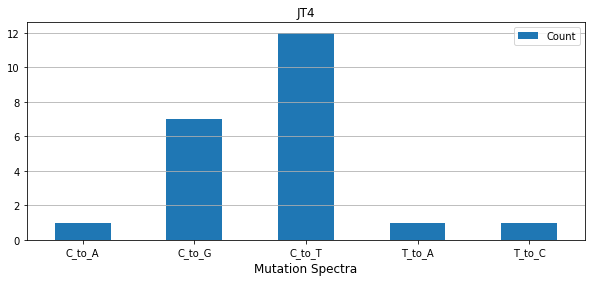

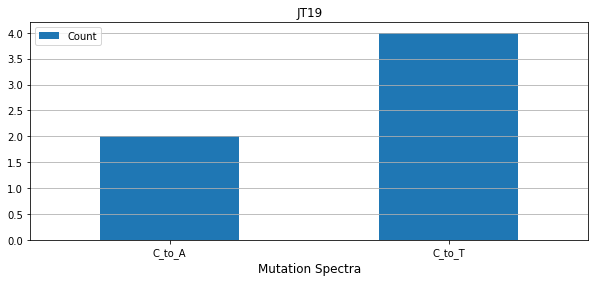

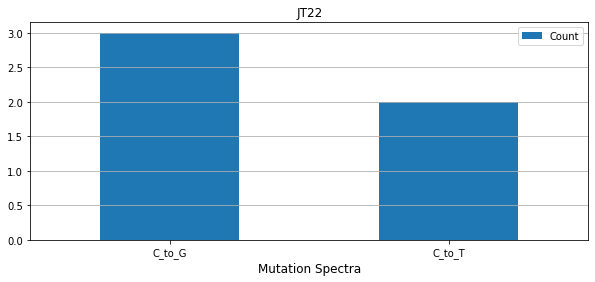

In [51]:
#set the name of the summary output file.
summary_output_name='summary_output.csv'

grouping_var=["SPECTRA"] # set to ['SPECTRA'] OR ["REF", "ALT"]

summary_df=pd.DataFrame(columns=["Sample","REF","ALT","Count"])

#set the df counter
counter=0

for frame in subtracted_df_list: #frames_list #subtracted_df_list

  #comment/uncomment below to filter the output to particular genomic regions 
  #frame = frame[frame["CHROM"] == "chr3"]
  #frame = frame[frame['POS'] > 240000]
  #frame = frame[frame['POS'] < 190000]
  #frame = frame[frame['REF'].isin(['G'])]

  frame = frame.groupby(grouping_var).size().to_frame("Count").reset_index()
  title = sample_names[counter].split("_")[0]
  frame["Sample"] = title
  summary_df = summary_df.append(frame, ignore_index=True)
  counter += 1

  #This plots the figure when grouping_var=["SPECTRA"]
  try:
    fig, ax = plt.subplots()
    plot = frame.plot(kind='bar',x="SPECTRA",  ax=ax, fontsize=10, grid=True, figsize=(10,4), title=title)
    plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
    ax.set_xlabel("Mutation Spectra", fontsize=12)
    plt.grid(axis='x')
    plot.figure.savefig('figures/'+title+'_spectra.png', transparent=False)
  except:
    print("Something went wrong during data plotting...")

print(summary_df)
summary_df.to_csv(summary_output_name, index=False)

## Other
Plot chromosome mutation spectra on chr3 and chr3R. 

The 2 input files for, need to have 4 columns: "sample", "C->N", "G->N", "Mutant". One file for the whole chr3 and one for chr3R.

    sample  C->N  G->N Mutant
0        1     4     0   UNG+
1        2    17     1   UNG+
2        3    10     0   UNG+
3        4     2     3   UNG+
4        5     4     2   UNG+
5        6     1     0   UNG+
6        7     3     0   UNG+
7        8    17     0   UNG+
8        9     2     0   UNG+
9       10     1     0   UNG+
10      11     5     0   UNG+
11      12     6     0   UNG+
12      13     2     0   UNG+
13      14     8     0   UNG+
14      15    18     0   UNG+
15      16     8     5   UNG+
16      17     6     0   UNG+
17      18    10     0   UNG+
18      19    10     0   UNG+
19      20     4     0   UNG+
20      21     2     1   UNG+
21      23     8     1   UNG+
22      24     3     1   UNG+
23      25     0     1   UNG+
24      26   109     0   UNG-
25      27    85     4   UNG-
26      28    13     0   UNG-
27      29    20     0   UNG-
28      30    20     1   UNG-
29      31   119     0   UNG-
30      32    27     0   UNG-
31      33    15     0   UNG-
32      34

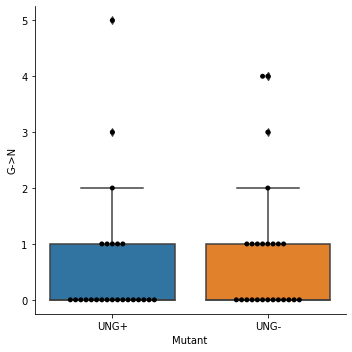

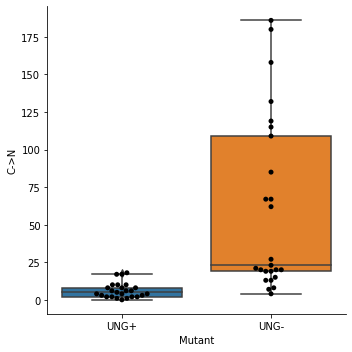

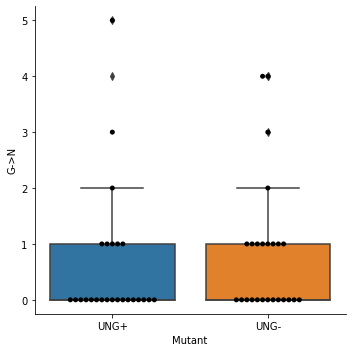

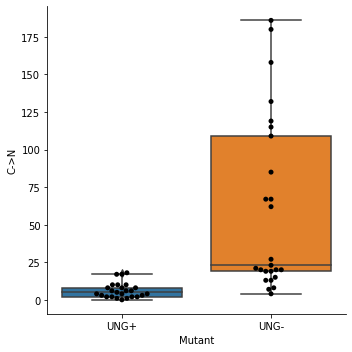

In [52]:
#chr3 analysis

ungs = pd.read_csv('/content/ungs.csv')
print(ungs)

kind="box"

g = sns.catplot(x="Mutant", y="G->N", kind=kind, data=ungs)
sns.swarmplot(x="Mutant", y="G->N", color="k", data=ungs, ax=g.ax)
g = sns.catplot(x="Mutant", y="C->N", kind=kind, data=ungs)
sns.swarmplot(x="Mutant", y="C->N", color="k", data=ungs, ax=g.ax)

#chr3_R analysis

ungs_R = pd.read_csv('/content/ungs_R.csv')

g = sns.catplot(x="Mutant", y="G->N", kind=kind, data=ungs_R)
sns.swarmplot(x="Mutant", y="G->N", color="k", data=ungs, ax=g.ax)
g = sns.catplot(x="Mutant", y="C->N", kind=kind, data=ungs_R)
sns.swarmplot(x="Mutant", y="C->N", color="k", data=ungs, ax=g.ax)

## Prototyping

This will check how many common mutations are there between the biological replicates. Mutations common between 2 or more samples were removed for the publication.

adding df of length 29 to masterDF
adding df of length 17 to masterDF
adding df of length 21 to masterDF
adding df of length 77 to masterDF
adding df of length 113 to masterDF
adding df of length 60 to masterDF
adding df of length 14 to masterDF
adding df of length 15 to masterDF
adding df of length 13 to masterDF
adding df of length 15 to masterDF
adding df of length 22 to masterDF
adding df of length 21 to masterDF
adding df of length 216 to masterDF
adding df of length 20 to masterDF
adding df of length 241 to masterDF
adding df of length 155 to masterDF
adding df of length 25 to masterDF
adding df of length 14 to masterDF
adding df of length 26 to masterDF
adding df of length 19 to masterDF
adding df of length 67 to masterDF
adding df of length 15 to masterDF
adding df of length 124 to masterDF
adding df of length 23 to masterDF
adding df of length 180 to masterDF
adding df of length 28 to masterDF
adding df of length 96 to masterDF
adding df of length 46 to masterDF
adding df of l

,CHROM,POS,counts
0,chr1,649,5
1,chr1,7747,1
2,chr1,15543,24
3,chr1,15546,25
4,chr1,31099,1
...,...,...,...
2531,chr9,386372,2
2532,chr9,386540,1
2533,chr9,400388,1
2534,chr9,406537,1


counts
1     2304
2      154
3       26
4        9
5        3
6        4
7        2
8        3
10       4
11       1
12       1
13       1
14       2
15       2
17       1
19       1
20       2
21       1
22       1
23       1
24       2
25       1
28       1
31       1
32       1
40       1
41       1
51       1
52       2
55       1
56       1
dtype: int64

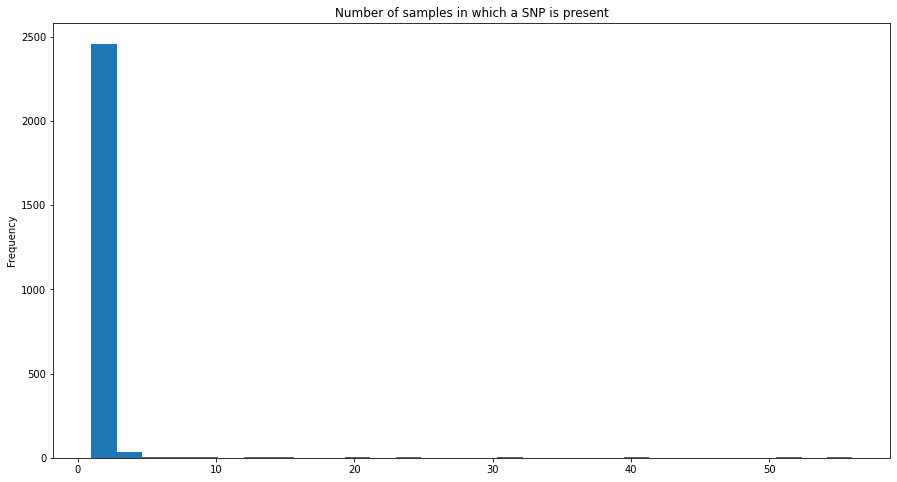

In [60]:
master_df = pd.DataFrame()
for df in frames_list:
  print(f'adding df of length {len(df)} to masterDF')
  master_df = master_df.append(df, ignore_index = True)
print("Finished creating MaserDF!")
master_df_counts = master_df.groupby(['CHROM', 'POS']).size().reset_index(name='counts')
print("Finished grouping common rows")
display(master_df_counts)

master_df_counts['counts'].plot(kind='hist', figsize=(15,8),bins=30, title="Number of samples in which a SNP is present")
#master_df_counts[master_df_counts['counts'] > 7]

master_df_counts.groupby(['counts']).size()

### Drawing a combined UNG1 Sample figure

saves the output figure into a PNG file.

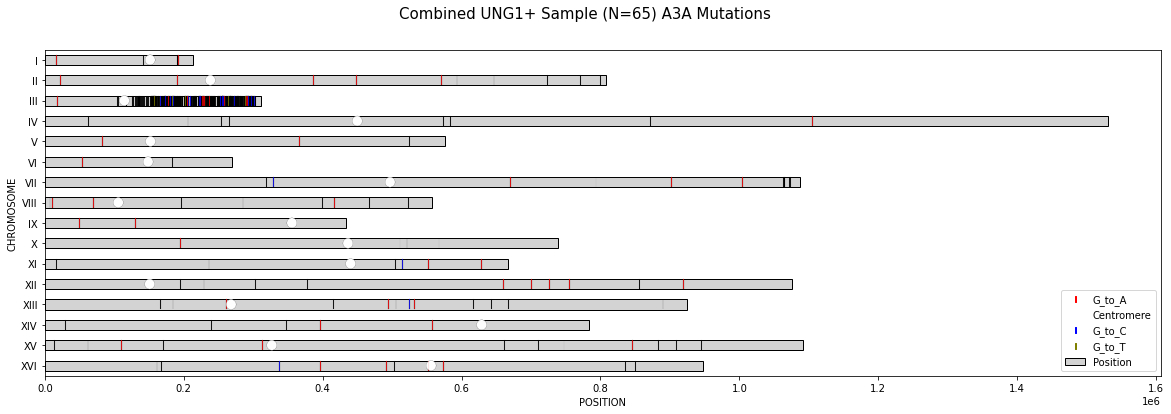

In [ ]:
all_snps_df = pd.read_csv("/content/JT_and_Rajula combined_UNG1.csv")
all_snps_df['SPECTRA_STRANDWISE'] = all_snps_df.apply(lambda row: findSpectraStrandwise(row.REF, row.ALT), axis=1)
drawCombinedSNPMap(all_snps_df, df_chr, centromeres, title="Combined UNG1+ Sample (N=65) A3A Mutations", sample_names=None)

### Analysis of G->C Probability on right arm of Chr3 vs Genomewide

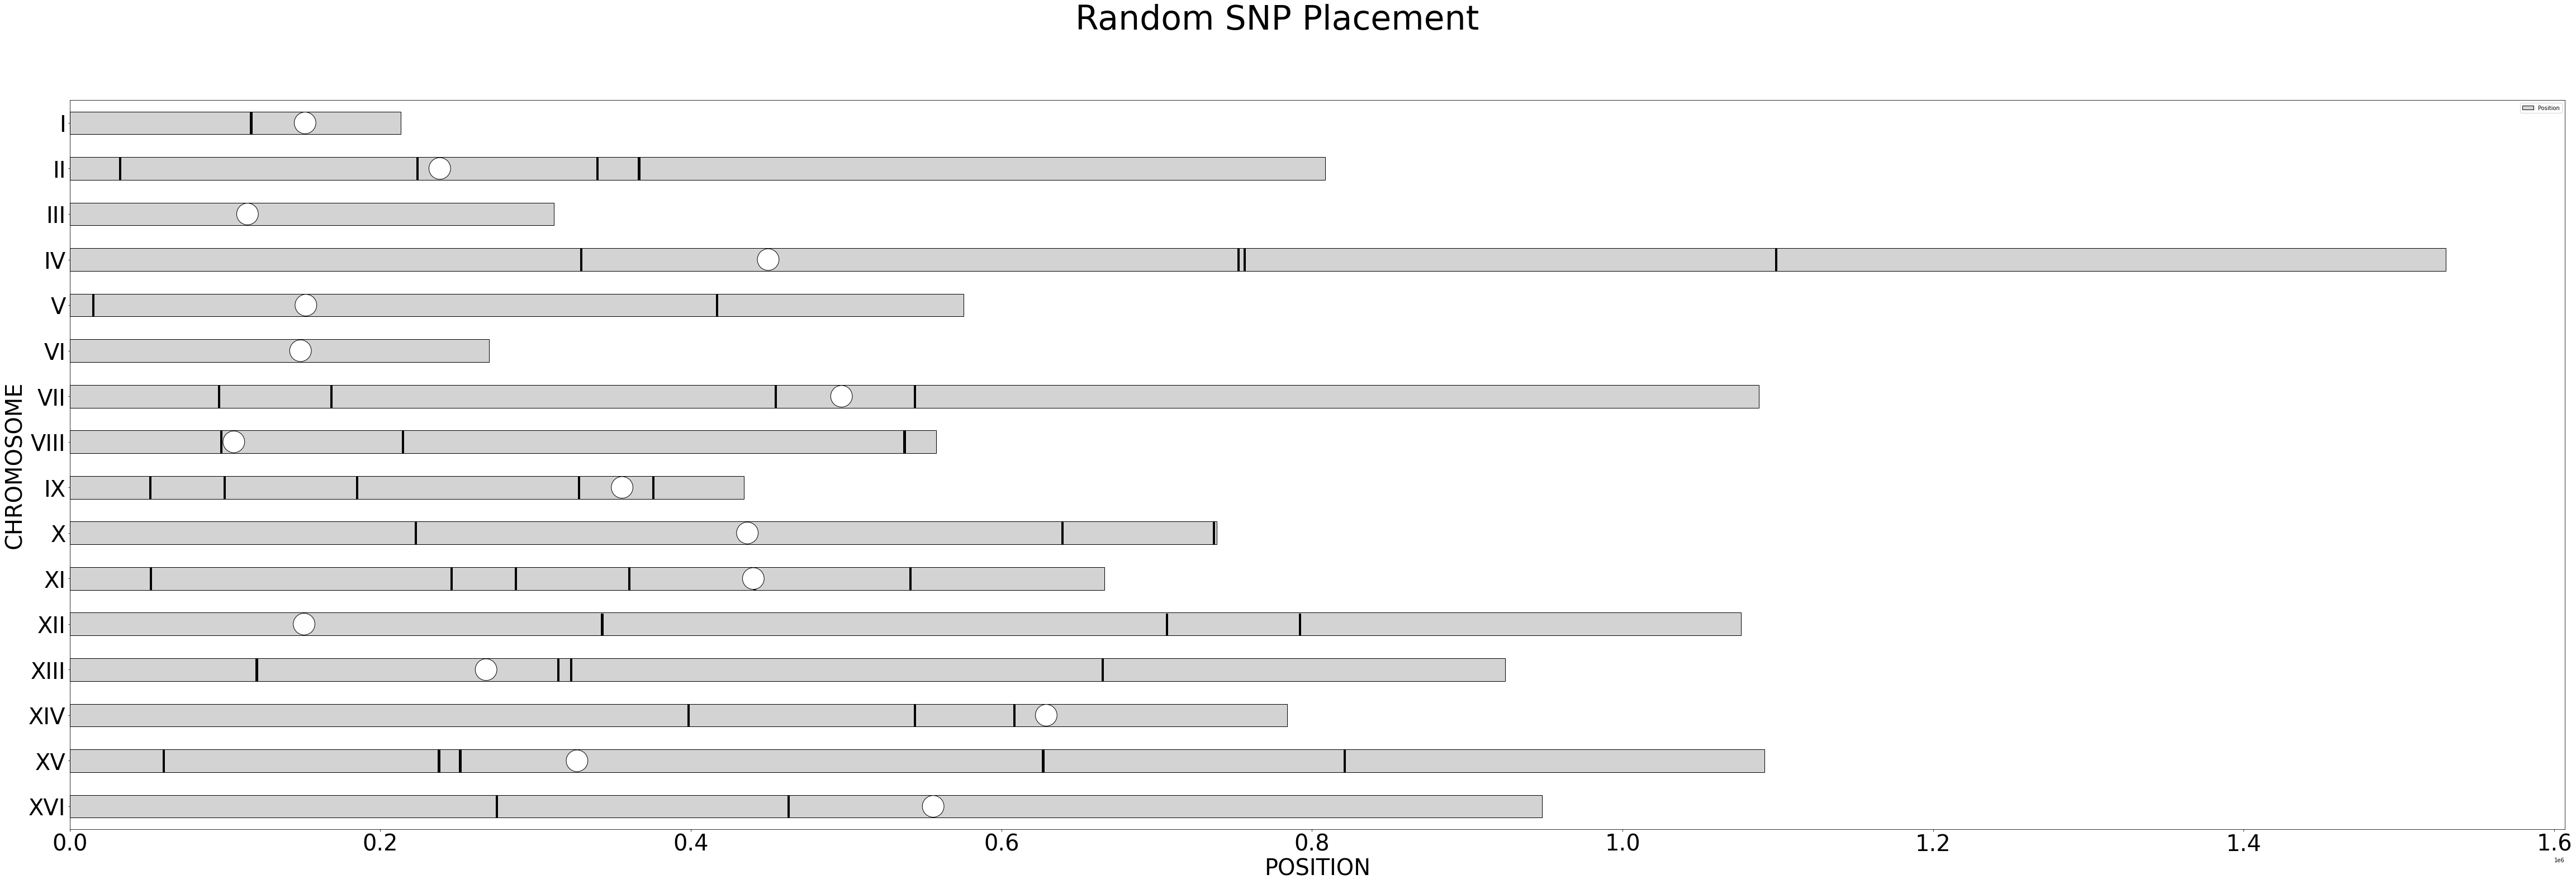

In [ ]:
#draws a map for randomly placed N loci in yeast genome
random_loci = generateRandomLoci(49, chromosomes)
assigned_random_loci = findChrInLinearGenome(chromosomes, random_loci)
df_random_snps = pd.DataFrame(assigned_random_loci, columns = ["CHROM","POS"])

df_random_snps["TYPE"] = 'ctrl'
df_random_snps["EVAL_AD"] = NaN
df_random_snps["REF"] = 'random'
df_random_snps["ALT"] = NaN
df_random_snps["SPECTRA"] = NaN

draw_random_SNPMap(df_random_snps, df_chr, centromeres, title="Random SNP Placement")

In [ ]:
#chr3 centromere pos: 114501

event_list=[]

#set the number of trials to simulate, the more the longer it takes
trials_to_simulate=100000

positions_per_genome=49+49 #(49-JT 49-Rajula G->Ns genomewide)

for i in range(trials_to_simulate):
  random_loci = generateRandomLoci(positions_per_genome, chromosomes)
  assigned_random_loci = findChrInLinearGenome(chromosomes, random_loci)
  df_random_snps = pd.DataFrame(assigned_random_loci, columns = ["CHROM","POS"])
  df_random_snps = df_random_snps[df_random_snps["CHROM"]=="chr3"]
  df_random_snps = df_random_snps[df_random_snps["POS"] > 114501]
  event_list.append(len(df_random_snps))

print(event_list)

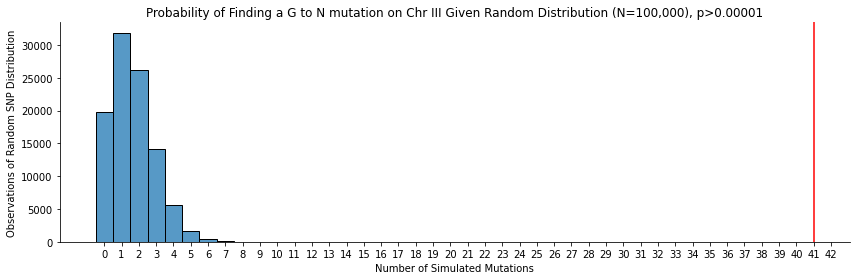

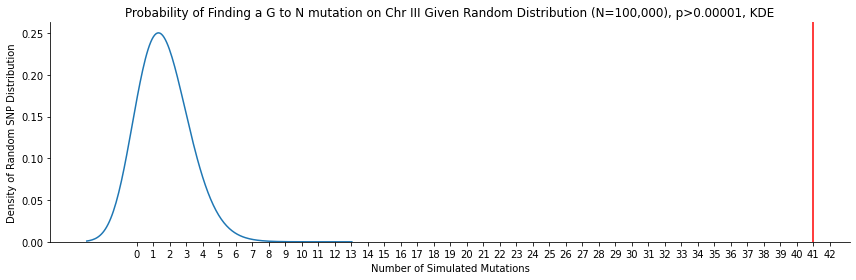

In [ ]:
#draw the figures and save to a png file

observed_events=26+15 #26 JT, #15 Rajula

#set title and other figure elements
title="Probability of Finding a G to N mutation on Chr III Given Random Distribution (N=100,000), p>0.00001"
sns.displot(event_list, discrete=True, bins=range(observed_events+1), height=4, aspect =3).set(title=title)
plt.axvline(observed_events, color="red")
plt.xticks(range(observed_events+2))
plt.xlabel("Number of Simulated Mutations", fontsize = 10)
plt.ylabel("Observations of Random SNP Distribution", fontsize = 10)
plt.tight_layout()
plt.savefig('figures/'+title+'.png', transparent=False, dpi=200)

title="Probability of Finding a G to N mutation on Chr III Given Random Distribution (N=100,000), p>0.00001, KDE"
sns.displot(event_list, kind='kde', bw_adjust=8, height=4, aspect =3).set(title=title)
plt.axvline(observed_events, color="red")
plt.xticks(range(observed_events+2))
plt.xlabel("Number of Simulated Mutations", fontsize = 10)
plt.ylabel("Density of Random SNP Distribution", fontsize = 10)
plt.tight_layout()
plt.savefig('figures/'+title+'.png', transparent=False, dpi=200)

## Save Output Figures
Send the output figures to the ZIP archive with a command below so they are easy to download/send.

In [ ]:
!zip -r /content/figures.zip /content/figures